<a href="https://colab.research.google.com/github/soheilpaper/-tft-2.4-ili9341-STM32/blob/master/Watermark%20remover/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/soheilpaper/-tft-2.4-ili9341-STM32/blob/master/Watermark%20remover/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{sweeps-video} -->

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{sweeps-video} -->

<div><img /></div>

<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

<div><img /></div>

Finding a machine learning model that meets your desired metric (such as model accuracy) is normally a redundant task that can take multiple iterations. To make matters worse, it might be unclear which hyperparameter combinations to use for a given training run.

Use W&B Sweeps to create an organized and efficient way to automatically search through combinations of hyperparameter values such as the learning rate, batch size, number of hidden layers, optimizer type and more to find values that optimize your model based on your desired metric.

In this tutorial you will create a hyperparameter search with W&B PyTorch integration. Follow along with a [video tutorial](http://wandb.me/sweeps-video)!

![](https://i.imgur.com/WVKkMWw.png)

## Sweeps: An Overview

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

1. **Define the sweep:** we do this by creating a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps/configuration) that specifies the parameters to search through, the search strategy, the optimization metric et all.

2. **Initialize the sweep:** with one line of code we initialize the sweep and pass in the dictionary of sweep configurations:
`sweep_id = wandb.sweep(sweep_config)`

3. **Run the sweep agent:** also accomplished with one line of code, we call `wandb.agent()` and pass the `sweep_id` to run, along with a function that defines your model architecture and trains it:
`wandb.agent(sweep_id, function=train)`


## Before you get started

Install W&B and import the W&B Python SDK into your notebook:

1. Install with `!pip install`:

In [2]:
!pip install wandb -Uq

2. Import W&B:

In [3]:
import wandb

3. Log in to W&B and provide your API key when prompted:

In [4]:
#wandb.login()
import wandb
wandb.login(key='22f2597b648c0fe02188c9eef60adfb0daa0728a')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bamudogukovol5 (bamudogukovol5-eghlym) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
!pip install ultralytics

In [ ]:
# Install dependencies if needed:
# !pip install ultralytics wandb

import wandb
from ultralytics import YOLO
from wandb.integration.ultralytics import add_wandb_callback

# --- 1. Set up wandb project (optional, for custom config) ---
# wandb.login()  # Uncomment if running for the first time
# wandb.init(project="my-logo-detection", config={"epochs": 50, "imgsz": 640})

# --- 2. Load YOLOv8 model ---
# Use a pre-trained model for transfer learning, or your own checkpoint
model = YOLO("yolov8n.pt")  # Or 'path/to/your/custom_logo_model.pt'

# --- 3. Add wandb callback for experiment tracking, model checkpointing, and visualization ---
add_wandb_callback(model, enable_model_checkpointing=True)

# --- 4. Train/Fine-tune the model on your custom dataset ---
# Make sure your data.yaml is correctly set up and your dataset is in YOLO format
model.train(
    project="my-logo-detection",      # wandb project name
    data="path/to/data.yaml",         # path to your data.yaml file
    epochs=50,                        # number of epochs
    imgsz=640,                        # image size
    device=0,                         # set to 0 for CUDA, or 'cpu'
    batch=16,                         # adjust batch size as needed
    save=True,                        # save checkpoints
    resume=False                      # resume from last checkpoint if needed
)

# --- 5. Finish the wandb run (optional, especially in notebooks) ---
wandb.finish()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


100%|██████████| 6.25M/6.25M [00:00<00:00, 74.3MB/s]


Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


#https://www.perplexity.ai/search/if-possible-see-this-code-and-iwg1EBJIS1qsPoOP.aXtsg#8

Yes, your code for **detecting and removing watermarks** can be adapted to help create a labeled dataset for YOLOv8 watermark detection. Instead of only removing the watermark, you can **save the detected bounding box as a YOLO label file** for each image, building a dataset automatically. This approach is commonly used in dataset bootstrapping, especially when manual annotation is expensive or slow[1][3][4][5].

Below is a **modified version of your code** that:
- Detects the watermark/logo region in each image
- Saves a YOLO-format `.txt` label file for each image (with bounding box)
- Optionally also saves the mask for visual verification

---

## **Modified Code for Automatic YOLOv8 Dataset Creation**

```python
import os
import numpy as np
from PIL import Image, ImageDraw, ImageChops
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import requests
from io import BytesIO
import gc

# Directories for dataset
dataset_dir = './watermark_dataset'
images_dir = os.path.join(dataset_dir, 'images', 'train')
labels_dir = os.path.join(dataset_dir, 'labels', 'train')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Download sample images (replace with your list)
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg",
    "https://i.sstatic.net/FyMuaSJV.jpg",
    "https://i.sstatic.net/26GPXl2M.jpg",
    "https://i.sstatic.net/D8kJfL4E.jpg"
]

def download_image(url, save_dir):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    filename = os.path.basename(url.split("?")[0])
    img_path = os.path.join(save_dir, filename)
    img.save(img_path)
    return img_path

# Download images
image_paths = [download_image(url, images_dir) for url in default_images]

# Load Florence-2 model and processor (for logo/watermark detection)
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
).to(device).eval()
florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

def get_logo_bbox(image, model, processor, device, max_bbox_percent=20):
    detection_keywords = ["logo", "watermark", "brand logo", "company logo"]
    for keyword in detection_keywords:
        task_prompt = ""
        parsed_answer = identify(task_prompt, image, keyword, model, processor, device)
        if "" in parsed_answer and "bboxes" in parsed_answer[""]:
            image_area = image.width * image.height
            for bbox in parsed_answer[""]["bboxes"]:
                x1, y1, x2, y2 = map(int, bbox)
                bbox_area = (x2 - x1) * (y2 - y1)
                if (bbox_area / image_area) * 100 <= max_bbox_percent:
                    return (x1, y1, x2, y2)
    return None

def save_yolo_label(bbox, image_size, label_path, class_id=0):
    x1, y1, x2, y2 = bbox
    img_w, img_h = image_size
    cx = ((x1 + x2) / 2) / img_w
    cy = ((y1 + y2) / 2) / img_h
    bw = (x2 - x1) / img_w
    bh = (y2 - y1) / img_h
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

# Process each image: detect watermark/logo and save YOLO label
for img_path in image_paths:
    img = Image.open(img_path)
    bbox = get_logo_bbox(img, florence_model, florence_processor, device)
    if bbox:
        label_name = os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        label_path = os.path.join(labels_dir, label_name)
        save_yolo_label(bbox, img.size, label_path)
        print(f"Labeled {img_path} with bbox {bbox}")
    else:
        print(f"No watermark/logo detected in {img_path}")

# Create data.yaml for YOLOv8
yaml_content = f"""train: {images_dir}
val: {images_dir}
nc: 1
names: ['watermark']
"""
with open(os.path.join(dataset_dir, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print("✅ Dataset is ready for YOLOv8 training.")

# Cleanup
del florence_model, florence_processor
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
```

---

## **How This Helps**

- **Automates bounding box annotation** for watermark/logo in each image using a detection model.
- **Saves YOLO-format label files** for each image, ready for YOLOv8 training[1][3][4].
- **Prepares the directory structure** and `data.yaml` file required by YOLOv8.

---

## **Next Steps**

1. **Review the auto-generated bounding boxes** (optional, for quality assurance).
2. **Train YOLOv8** with your dataset:
   ```bash
   yolo task=detect mode=train model=yolov8n.pt data=./watermark_dataset/data.yaml epochs=50 imgsz=640
   ```
3. **Iterate and improve**: If needed, manually correct label files for higher accuracy.

---

**This approach leverages your watermark detection pipeline to bootstrap a labeled dataset for YOLOv8, significantly speeding up the annotation process for watermark/logo detection tasks.**

---

**References:**  
- [How to train YOLOv8 on a custom dataset][1]  
- [YOLOv8 watermark detection model example][2]  
- [PITA watermark dataset and YOLOv8 training][3]  
- [YOLOv8 logo detection and dataset structure][4]  
- [Picsellia YOLOv8 custom dataset tutorial][5]

Citations:
[1] https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/
[2] https://huggingface.co/mnemic/watermarks_yolov8
[3] https://github.com/OrdinaryDev83/dnn-watermark
[4] https://www.kaggle.com/code/skorykrodion/yolov8-logo-detection-and-classification
[5] https://www.picsellia.com/post/how-to-train-yolov8-on-a-custom-dataset
[6] https://yolov8.org
[7] https://www.reddit.com/r/StableDiffusion/comments/1hvxpsd/tool_watermark_detection_model_95_accuracy/
[8] https://dev.to/irubtsov/yolov8-classifier-trained-on-a-custom-dataset-1994

---
Answer from Perplexity: pplx.ai/share

https://www.perplexity.ai/search/if-possible-see-this-code-and-iwg1EBJIS1qsPoOP.aXtsg#12
Certainly! Below are two complete Python code blocks:

---

## 1️⃣ Dataset Building & Auto-Labeling Script

This script downloads sample images, detects watermark bounding boxes automatically using the Florence-2 model, saves YOLO-format labels, and creates the `data.yaml` file for YOLOv8 training.

```python
import os
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import gc

# Dataset directories
dataset_dir = '/content/watermark_dataset'
images_dir = os.path.join(dataset_dir, 'images', 'train')
labels_dir = os.path.join(dataset_dir, 'labels', 'train')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Sample images URLs
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg",
    "https://i.sstatic.net/FyMuaSJV.jpg",
    "https://i.sstatic.net/26GPXl2M.jpg",
    "https://i.sstatic.net/D8kJfL4E.jpg"
]

def download_image(url, save_dir):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    filename = os.path.basename(url.split("?")[0])
    img_path = os.path.join(save_dir, filename)
    img.save(img_path)
    return img_path

# Download images
image_paths = [download_image(url, images_dir) for url in default_images]

# Load Florence-2 model and processor for detection
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
).to(device).eval()
florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

def get_logo_bbox(image, model, processor, device, max_bbox_percent=20):
    detection_keywords = ["logo", "watermark", "brand logo", "company logo"]
    for keyword in detection_keywords:
        task_prompt = ""
        parsed_answer = identify(task_prompt, image, keyword, model, processor, device)
        if "" in parsed_answer and "bboxes" in parsed_answer[""]:
            image_area = image.width * image.height
            for bbox in parsed_answer[""]["bboxes"]:
                x1, y1, x2, y2 = map(int, bbox)
                bbox_area = (x2 - x1) * (y2 - y1)
                if (bbox_area / image_area) * 100 <= max_bbox_percent:
                    return (x1, y1, x2, y2)
    return None

def save_yolo_label(bbox, image_size, label_path, class_id=0):
    x1, y1, x2, y2 = bbox
    img_w, img_h = image_size
    cx = ((x1 + x2) / 2) / img_w
    cy = ((y1 + y2) / 2) / img_h
    bw = (x2 - x1) / img_w
    bh = (y2 - y1) / img_h
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

# Auto-label all images
for img_path in image_paths:
    img = Image.open(img_path)
    bbox = get_logo_bbox(img, florence_model, florence_processor, device)
    if bbox:
        label_name = os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        label_path = os.path.join(labels_dir, label_name)
        save_yolo_label(bbox, img.size, label_path)
        print(f"Labeled {img_path} with bbox {bbox}")
    else:
        print(f"No watermark/logo detected in {img_path}")

# Create data.yaml for YOLOv8 with absolute paths
yaml_content = f"""train: {images_dir}
val: {images_dir}
nc: 1
names: ['watermark']
"""
with open(os.path.join(dataset_dir, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print("✅ Dataset is ready for YOLOv8 training.")

# Cleanup
del florence_model, florence_processor
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
```

---

## 2️⃣ YOLOv8 Training Script with wandb Integration

Make sure you have installed `ultralytics` and `wandb` packages.

```python
# !pip install ultralytics wandb

import wandb
import torch
from ultralytics import YOLO
from wandb.integration.ultralytics import add_wandb_callback

# Initialize wandb run (optional)
wandb.init(project="watermark-detection-yolov8")

# Load pretrained YOLOv8 model for transfer learning
model = YOLO("yolov8n.pt")  # or your custom model path

# Add wandb callback for logging
add_wandb_callback(model, enable_model_checkpointing=True)

# Train the model
model.train(
    data="/content/watermark_dataset/data.yaml",  # absolute path to your data.yaml
    epochs=50,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    project="watermark-detection-yolov8",
    name="yolov8-watermark-run"
)

# Finish wandb run (important in notebooks)
wandb.finish()
```

---

# Notes

- Adjust paths if you run outside `/content`.
- Use absolute paths in `data.yaml` to avoid path resolution errors.
- You can monitor training live on your wandb dashboard.
- After training, use `yolo task=detect mode=val` or `mode=predict` for evaluation and inference.

---

This combined setup automates dataset creation and launches wandb-tracked YOLOv8 training for watermark detection.

Citations:
[1] https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/
[2] https://github.com/OrdinaryDev83/dnn-watermark
[3] https://www.kaggle.com/code/skorykrodion/yolov8-logo-detection-and-classification
[4] https://learnopencv.com/train-yolov8-on-custom-dataset/
[5] https://fxis.ai/edu/how-to-use-the-yolov8-detection-model-for-watermarks-in-images/
[6] https://fxis.ai/edu/detecting-watermarks-with-yolov8-a-comprehensive-guide/
[7] https://fxis.ai/edu/how-to-use-a-yolov8-model-for-watermark-detection/
[8] https://huggingface.co/mnemic/watermarks_yolov8
[9] https://www.youtube.com/watch?v=gRAyOPjQ9_s
[10] https://civitai.com/articles/4080/training-a-custom-adetailer-model-with-yolov8-detection-model

---
Answer from Perplexity: https://www.perplexity.ai/search/if-possible-see-this-code-and-iwg1EBJIS1qsPoOP.aXtsg?utm_source=copy_output

In [ ]:

import os
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import gc

# Dataset directories
dataset_dir = '/content/watermark_dataset'
images_dir = os.path.join(dataset_dir, 'images', 'train')
labels_dir = os.path.join(dataset_dir, 'labels', 'train')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Sample images URLs
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg",
    "https://i.sstatic.net/FyMuaSJV.jpg",
    "https://i.sstatic.net/26GPXl2M.jpg",
    "https://i.sstatic.net/D8kJfL4E.jpg"
]

def download_image(url, save_dir):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    filename = os.path.basename(url.split("?")[0])
    img_path = os.path.join(save_dir, filename)
    img.save(img_path)
    return img_path

# Download images
image_paths = [download_image(url, images_dir) for url in default_images]

# Load Florence-2 model and processor for detection
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
).to(device).eval()
florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

def get_logo_bbox(image, model, processor, device, max_bbox_percent=20):
    detection_keywords = ["logo", "watermark", "brand logo", "company logo"]
    for keyword in detection_keywords:
        task_prompt = "<OPEN_VOCABULARY_DETECTION>"
        parsed_answer = identify(task_prompt, image, keyword, model, processor, device)
        if "<OPEN_VOCABULARY_DETECTION>" in parsed_answer and "bboxes" in parsed_answer["<OPEN_VOCABULARY_DETECTION>"]:
            image_area = image.width * image.height
            for bbox in parsed_answer["<OPEN_VOCABULARY_DETECTION>"]["bboxes"]:
                x1, y1, x2, y2 = map(int, bbox)
                bbox_area = (x2 - x1) * (y2 - y1)
                if (bbox_area / image_area) * 100 <= max_bbox_percent:
                    return (x1, y1, x2, y2)
    return None

def save_yolo_label(bbox, image_size, label_path, class_id=0):
    x1, y1, x2, y2 = bbox
    img_w, img_h = image_size
    cx = ((x1 + x2) / 2) / img_w
    cy = ((y1 + y2) / 2) / img_h
    bw = (x2 - x1) / img_w
    bh = (y2 - y1) / img_h
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

# Auto-label all images
for img_path in image_paths:
    img = Image.open(img_path)
    bbox = get_logo_bbox(img, florence_model, florence_processor, device)
    if bbox:
        label_name = os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        label_path = os.path.join(labels_dir, label_name)
        save_yolo_label(bbox, img.size, label_path)
        print(f"Labeled {img_path} with bbox {bbox}")
    else:
        print(f"No watermark/logo detected in {img_path}")

# Create data.yaml for YOLOv8 with absolute paths
yaml_content = f"""train: {images_dir}
val: {images_dir}
nc: 1
names: ['watermark']
"""
with open(os.path.join(dataset_dir, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print("✅ Dataset is ready for YOLOv8 training.")

# Cleanup
del florence_model, florence_processor
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# !pip install ultralytics wandb

import wandb
import torch
from ultralytics import YOLO
from wandb.integration.ultralytics import add_wandb_callback

# Initialize wandb run (optional)
wandb.init(project="watermark-detection-yolov8")

# Load pretrained YOLOv8 model for transfer learning
model = YOLO("yolov8n.pt")  # or your custom model path

# Add wandb callback for logging
add_wandb_callback(model, enable_model_checkpointing=True)

# Train the model
model.train(
    data="/content/watermark_dataset/data.yaml",  # absolute path to your data.yaml
    epochs=50,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    project="watermark-detection-yolov8",
    name="yolov8-watermark-run"
)

# Finish wandb run (important in notebooks)
wandb.finish()

In [ ]:
# Install required packages if not already installed
# !pip install ultralytics pillow

import os
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Optional: Enable file upload in Colab or Jupyter
try:
    from google.colab import files
    COLAB = True
except ImportError:
    COLAB = False

# 1. Load your trained YOLOv8 model
model_path = '/content/watermark-detection-yolov8/yolov8-watermark-run2/weights/best.pt'  # update this path if needed
model = YOLO(model_path)

# 2. Prepare a list of test images (default images)
test_images = [
    "/content/watermark_dataset/images/train/pBClQA3f.jpg",
    "/content/watermark_dataset/images/train/LhZcESfd.jpg",
    "/content/watermark_dataset/images/train/EDdJ8syZ.jpg",
    "/content/watermark_dataset/images/train/FyMuaSJV.jpg",
    "/content/watermark_dataset/images/train/26GPXl2M.jpg",
    "/content/watermark_dataset/images/train/D8kJfL4E.jpg"
]

def detect_and_display(image_path):
    results = model(image_path)
    # Show image with detections
    results[0].show()  # Ultralytics will display the image with boxes

    # If you want to display in notebook with matplotlib:
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detections for {os.path.basename(image_path)}")
    plt.show()

# 3. Run detection on default test images
for img_path in test_images:
    print(f"Detecting watermarks in {img_path}")
    detect_and_display(img_path)

# 4. Optionally, allow user to upload new images and run detection
if COLAB:
    print("Upload new images to test:")
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Detecting watermarks in uploaded image {filename}")
        detect_and_display(filename)

https://www.perplexity.ai/search/if-possible-see-this-code-and-iwg1EBJIS1qsPoOP.aXtsg#17

Certainly! Here is a **three-block code pipeline** for Florence-2 watermark/logo detection and removal, covering:

1. **Dataset creation and labeling** using Florence-2 for automatic bounding box annotation.
2. **Fine-tuning (training) the Florence-2 model** on your labeled dataset.
3. **Testing/inference**: upload or select images, detect watermarks/logos, and optionally show inpainted (removed watermark) results.

---

## 1️⃣ Dataset Creation & Labeling with Florence-2

This block uses Florence-2 to auto-label bounding boxes for logos/watermarks in your images and saves them in a format suitable for fine-tuning.

```python
import os
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import json
import gc

# Dataset directories
dataset_dir = '/content/florence_dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Sample images (add your own or upload)
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg"
]

def download_image(url, save_dir):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    filename = os.path.basename(url.split("?")[0])
    img_path = os.path.join(save_dir, filename)
    img.save(img_path)
    return img_path

image_paths = [download_image(url, images_dir) for url in default_images]

# Load Florence-2 model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
).to(device).eval()
florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

# Save Florence-style annotation (JSON, one per image)
for img_path in image_paths:
    img = Image.open(img_path)
    task_prompt = ""
    text_input = "logo"
    parsed = identify(task_prompt, img, text_input, florence_model, florence_processor, device)
    bboxes = parsed.get("", {}).get("bboxes", [])
    label_file = os.path.splitext(os.path.basename(img_path))[0] + ".json"
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'w') as f:
        json.dump({"bboxes": bboxes}, f)
    print(f"Labeled {img_path} with {len(bboxes)} bbox(es)")

del florence_model, florence_processor
gc.collect()
```

---

## 2️⃣ Fine-Tune Florence-2 on Your Labeled Dataset

**Note:** Florence-2 is a large vision-language model. Fine-tuning it requires significant compute and is typically done with a custom training script or a library that supports Florence-2. Below is a **conceptual template**; adapt as needed for your environment and dataset size.

```python
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import torch

# Load Florence-2 model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

# Prepare your dataset (images + Florence-style JSON labels)
# Example: build a HuggingFace Dataset from your images and label files
data = []
for fname in os.listdir(images_dir):
    img_path = os.path.join(images_dir, fname)
    label_path = os.path.join(labels_dir, os.path.splitext(fname)[0] + ".json")
    if os.path.exists(label_path):
        with open(label_path) as f:
            bboxes = json.load(f)["bboxes"]
        data.append({"image": img_path, "bboxes": bboxes})

dataset = Dataset.from_list(data)

def preprocess(example):
    image = Image.open(example["image"]).convert("RGB")
    # Florence-2 expects a prompt and image; adjust as needed for your task
    prompt = "logo"
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    # Add your label processing here if needed
    return {**inputs, "labels": example["bboxes"]}

dataset = dataset.map(preprocess)

# Training arguments (adjust as needed)
training_args = TrainingArguments(
    output_dir="./florence2-finetuned",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    # Add compute_metrics, data_collator, etc. as needed
)

trainer.train()
```
*This code is a conceptual template. Florence-2 fine-tuning is not as plug-and-play as YOLOv8 and may require adaptation based on your dataset and compute resources. See [Florence-2 docs][4][5] and [community tools][1][2][3][6][8] for more.*

---

## 3️⃣ Testing/Inference: Detect & Remove Watermarks with Florence-2

This block allows you to upload or select images, detects logos/watermarks using Florence-2, and (optionally) removes them using LaMA inpainting.

```python
import os
from PIL import Image, ImageDraw, ImageChops
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from iopaint.model_manager import ModelManager
from iopaint.schema import HDStrategy, LDMSampler, InpaintRequest as Config
import gc

# Load Florence-2 model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).to(device).eval()
florence_processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

# Try to load LaMA for inpainting
try:
    lama_manager = ModelManager(name="lama", device=device)
    inpaint_model = "lama"
except NotImplementedError:
    print("⚠️ LaMA not available, falling back to cv2 inpainting.")
    lama_manager = ModelManager(name="cv2", device=device)
    inpaint_model = "cv2"

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

def get_logo_mask(image, model, processor, device, max_bbox_percent=20):
    detection_keywords = ["logo", "brand logo", "company logo"]
    combined_mask = Image.new("L", image.size, 0)
    for keyword in detection_keywords:
        task_prompt = ""
        parsed_answer = identify(task_prompt, image, keyword, model, processor, device)
        temp_mask = Image.new("L", image.size, 0)
        draw = ImageDraw.Draw(temp_mask)
        if "" in parsed_answer and "bboxes" in parsed_answer[""]:
            image_area = image.width * image.height
            for bbox in parsed_answer[""]["bboxes"]:
                x1, y1, x2, y2 = map(int, bbox)
                bbox_area = (x2 - x1) * (y2 - y1)
                if (bbox_area / image_area) * 100 <= max_bbox_percent:
                    draw.rectangle([x1, y1, x2, y2], fill=255)
        combined_mask = ImageChops.lighter(combined_mask, temp_mask)
        temp_mask.close()
        del temp_mask
        gc.collect()
    return combined_mask

def process_image_with_inpainter(image, mask, model_manager):
    config = Config(
        ldm_steps=80,
        ldm_sampler=LDMSampler.ddim,
        hd_strategy=HDStrategy.CROP,
        hd_strategy_crop_margin=180,
        hd_strategy_crop_trigger_size=600,
        hd_strategy_resize_limit=2048,
    )
    img_np = np.array(image)
    mask_np = np.array(mask)
    result = model_manager(img_np, mask_np, config)
    if result.dtype in [np.float64, np.float32]:
        result = np.clip(result, 0, 255).astype(np.uint8)
    return result

# Example: process a test image
test_image_path = image_paths[0]  # or upload a new image
with Image.open(test_image_path) as image:
    image = image.convert("RGB")
    mask = get_logo_mask(image, florence_model, florence_processor, device)
    print("Detected logo mask:")
    mask.show()
    # Inpaint to remove logo
    result_arr = process_image_with_inpainter(image, mask, lama_manager)
    result_image = Image.fromarray(result_arr)
    print("Original image:")
    image.show()
    print("Image with watermark/logo removed:")
    result_image.show()
```

---

## Notes

- **Block 1:** Creates a Florence-2-style labeled dataset (JSON bounding boxes).
- **Block 2:** Fine-tunes Florence-2 (conceptual template; Florence-2 fine-tuning is advanced and may require more setup).
- **Block 3:** Runs detection and (optionally) inpainting/removal on test images.

**References:**  
- [Florence-2 official model][4][5]  
- [WatermarkRemover-AI][1]  
- [Florence-2 dataset conversion][6]  
- [Florence-2 vs YOLOv8 comparison][8]

If you need a ready-to-use Florence-2 fine-tuning pipeline or want to convert YOLOv8 data to Florence-2 format, see [Roboflow’s conversion guide][6].

Citations:
[1] https://github.com/D-Ogi/WatermarkRemover-AI
[2] https://github.com/Damarcreative/rem-wm
[3] https://dataloop.ai/library/model/miaoshouai_florence-2-large-promptgen-v15/
[4] https://huggingface.co/microsoft/Florence-2-large
[5] https://openaccess.thecvf.com/content/CVPR2024/papers/Xiao_Florence-2_Advancing_a_Unified_Representation_for_a_Variety_of_Vision_CVPR_2024_paper.pdf
[6] https://roboflow.com/convert/yolov8-pytorch-txt-florence-2
[7] https://repos.ecosyste.ms/hosts/GitHub/topics/florence-2
[8] https://www.sievedata.com/resources/comparing-zero-shot-object-detection-yolo-florence
[9] https://github.com/ultralytics/ultralytics/issues/8057

---
Answer from Perplexity: https://www.perplexity.ai/search/if-possible-see-this-code-and-iwg1EBJIS1qsPoOP.aXtsg?utm_source=copy_output

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! pip install datasets

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import json
import gc

# Dataset directories
dataset_dir = '/content/florence_dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Sample images (add your own or upload)
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg"
]

def download_image(url, save_dir):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    filename = os.path.basename(url.split("?")[0])
    img_path = os.path.join(save_dir, filename)
    img.save(img_path)
    return img_path

image_paths = [download_image(url, images_dir) for url in default_images]

# Load Florence-2 model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
).to(device).eval()
florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

# Save Florence-style annotation (JSON, one per image)
for img_path in image_paths:
    img = Image.open(img_path)
    task_prompt = "<OPEN_VOCABULARY_DETECTION>"
    text_input = "logo"
    parsed = identify(task_prompt, img, text_input, florence_model, florence_processor, device)
    bboxes = parsed.get("<OPEN_VOCABULARY_DETECTION>", {}).get("bboxes", [])
    label_file = os.path.splitext(os.path.basename(img_path))[0] + ".json"
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'w') as f:
        json.dump({"bboxes": bboxes}, f)
    print(f"Labeled {img_path} with {len(bboxes)} bbox(es)")

del florence_model, florence_processor
gc.collect()

In [ ]:
# Install dependencies if needed
# !pip install transformers datasets peft

import os
import torch
from datasets import Dataset
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# Use Florence-2 base for lower VRAM usage
CHECKPOINT = "microsoft/Florence-2-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(device)

# LoRA config without 'use_rslora' to avoid compatibility issues
TARGET_MODULES = ["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"]
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=TARGET_MODULES,
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    init_lora_weights="gaussian"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Prepare dataset from labeled files
examples = []
images_dir = '/content/florence2_od/images'
labels_dir = '/content/florence2_od/labels'
for fname in os.listdir(images_dir):
    img_path = os.path.join(images_dir, fname)
    label_path = os.path.join(labels_dir, fname.rsplit('.', 1)[0] + ".txt")
    if os.path.exists(label_path):
        with open(label_path) as f:
            response = f.read().strip()
        examples.append({"image": img_path, "prompt": "<OD>", "response": response})

dataset = Dataset.from_list(examples)

def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((224, 224))
    inputs = processor(text=example["prompt"], images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    if pixel_values.ndim == 5:
        pixel_values = pixel_values.squeeze(1)
    labels = processor.tokenizer.encode(example["response"], return_tensors="pt")[0]
    return {
        "input_ids": inputs["input_ids"][0],
        "pixel_values": pixel_values[0],
        "labels": labels,
    }

processed_dataset = dataset.map(preprocess)

training_args = TrainingArguments(
    output_dir="/content/florence2_od_finetuned",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=1,
    save_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
)

trainer.train()

In [ ]:
!ls -a /content/florence2_od_finetuned

In [ ]:
!pip install iopaint

In [ ]:
# --- 1. Merge LoRA adapter with base Florence-2 model ---

from transformers import AutoModelForCausalLM, AutoProcessor
from peft import PeftModel
import torch

# Paths
adapter_checkpoint = "/content/florence2_od_finetuned/checkpoint-3"
base_model_id = "microsoft/Florence-2-base"  # Use ONLY this base model
merged_model_dir = "/content/florence2_od_finetuned_merged"

# Load base model (must be official Florence-2-base)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True
)

# Load LoRA adapter and merge
peft_model = PeftModel.from_pretrained(base_model, adapter_checkpoint)
merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained(merged_model_dir)

# Save processor/tokenizer (optional, for completeness)
processor = AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)
processor.save_pretrained(merged_model_dir)

print("✅ LoRA adapter merged and model saved to:", merged_model_dir)

# --- 2. Load merged model and processor for inference ---

device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    merged_model_dir,
    trust_remote_code=True,
    local_files_only=True
).to(device).eval()

florence_processor = AutoProcessor.from_pretrained(
    merged_model_dir,
    trust_remote_code=True,
    local_files_only=True
)

# --- 3. Watermark/logo detection and inpainting ---

import numpy as np
from PIL import Image, ImageDraw, ImageChops
from iopaint.model_manager import ModelManager
from iopaint.schema import HDStrategy, LDMSampler, InpaintRequest as Config
import gc

# Load LaMA inpainting model or fallback to cv2
try:
    lama_manager = ModelManager(name="lama", device=device)
except NotImplementedError:
    print("⚠️ LaMA model not available, falling back to cv2 inpainting.")
    lama_manager = ModelManager(name="cv2", device=device)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"].squeeze(1) if inputs["pixel_values"].ndim == 5 else inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

def get_logo_mask(image, model, processor, device, max_bbox_percent=20):
    detection_keywords = ["logo", "brand logo", "company logo"]
    combined_mask = Image.new("L", image.size, 0)
    for keyword in detection_keywords:
        task_prompt = "<OPEN_VOCABULARY_DETECTION>"
        parsed_answer = identify(task_prompt, image, keyword, model, processor, device)
        temp_mask = Image.new("L", image.size, 0)
        draw = ImageDraw.Draw(temp_mask)
        if "<OPEN_VOCABULARY_DETECTION>" in parsed_answer and "bboxes" in parsed_answer["<OPEN_VOCABULARY_DETECTION>"]:
            image_area = image.width * image.height
            for bbox in parsed_answer["<OPEN_VOCABULARY_DETECTION>"]["bboxes"]:
                x1, y1, x2, y2 = map(int, bbox)
                bbox_area = (x2 - x1) * (y2 - y1)
                if (bbox_area / image_area) * 100 <= max_bbox_percent:
                    draw.rectangle([x1, y1, x2, y2], fill=255)
        combined_mask = ImageChops.lighter(combined_mask, temp_mask)
        temp_mask.close()
        del temp_mask
        gc.collect()
    return combined_mask

def inpaint_image(image, mask, model_manager):
    config = Config(
        ldm_steps=80,
        ldm_sampler=LDMSampler.ddim,
        hd_strategy=HDStrategy.CROP,
        hd_strategy_crop_margin=180,
        hd_strategy_crop_trigger_size=600,
        hd_strategy_resize_limit=2048,
    )
    img_np = np.array(image)
    mask_np = np.array(mask)
    result = model_manager(img_np, mask_np, config)
    if result.dtype in [np.float64, np.float32]:
        result = np.clip(result, 0, 255).astype(np.uint8)
    return result

# --- Test on your image (change path as needed) ---
test_image_path = "/content/florence2_od/images/sample_test.jpg"  # Change to your test image

with Image.open(test_image_path) as image:
    image = image.convert("RGB")
    print("Detecting watermark/logo mask...")
    mask = get_logo_mask(image, florence_model, florence_processor, device)
    mask.show(title="Detected Logo Mask")

    print("Removing watermark/logo with inpainting...")
    result_arr = inpaint_image(image, mask, lama_manager)
    result_image = Image.fromarray(result_arr)

    print("Original Image:")
    image.show()

    print("Image with watermark/logo removed:")
    result_image.show()

# again training the Florence

In [ ]:
!rm -rd /content/florence2_od_finetuned

In [ ]:

import os
from datasets import Dataset
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

CHECKPOINT = "microsoft/Florence-2-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(device)

# LoRA config (no use_rslora)
TARGET_MODULES = ["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"]
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=TARGET_MODULES,
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    init_lora_weights="gaussian"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Prepare dataset
examples = []
images_dir = '/content/florence2_od/images'
labels_dir = '/content/florence2_od/labels'
for fname in os.listdir(images_dir):
    img_path = os.path.join(images_dir, fname)
    label_path = os.path.join(labels_dir, fname.rsplit('.', 1)[0] + ".txt")
    if os.path.exists(label_path):
        with open(label_path) as f:
            response = f.read().strip()
        examples.append({"image": img_path, "prompt": "<OD>", "response": response})

dataset = Dataset.from_list(examples)

def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((224, 224))
    inputs = processor(text=example["prompt"], images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    if pixel_values.ndim == 5:
        pixel_values = pixel_values.squeeze(1)
    labels = processor.tokenizer.encode(example["response"], return_tensors="pt")[0]
    return {
        "input_ids": inputs["input_ids"][0],
        "pixel_values": pixel_values[0],
        "labels": labels,
    }

processed_dataset = dataset.map(preprocess)

training_args = TrainingArguments(
    output_dir="/content/florence2_od_finetuned",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=1,
    save_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
)

trainer.train()
# Your LoRA adapter will be saved in /content/florence2_od_finetuned/checkpoint-3 or similar.

In [ ]:
# Install dependencies if needed
# !pip install transformers datasets peft

import os
import torch
from datasets import Dataset
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# Use Florence-2-base for manageable VRAM usage
CHECKPOINT = "microsoft/Florence-2-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(device)

# Configure LoRA (without unsupported 'use_rslora')
TARGET_MODULES = ["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"]
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=TARGET_MODULES,
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    init_lora_weights="gaussian"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Prepare dataset from your labeled images
examples = []
images_dir = '/content/florence2_od/images'
labels_dir = '/content/florence2_od/labels'
for fname in os.listdir(images_dir):
    img_path = os.path.join(images_dir, fname)
    label_path = os.path.join(labels_dir, fname.rsplit('.', 1)[0] + ".txt")
    if os.path.exists(label_path):
        with open(label_path) as f:
            response = f.read().strip()
        examples.append({"image": img_path, "prompt": "<OD>", "response": response})

dataset = Dataset.from_list(examples)

def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((224, 224))
    inputs = processor(text=example["prompt"], images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    if pixel_values.ndim == 5:
        pixel_values = pixel_values.squeeze(1)
    labels = processor.tokenizer.encode(example["response"], return_tensors="pt")[0]
    return {
        "input_ids": inputs["input_ids"][0],
        "pixel_values": pixel_values[0],
        "labels": labels,
    }

processed_dataset = dataset.map(preprocess)

training_args = TrainingArguments(
    output_dir="/content/florence2_od_finetuned",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=1,
    save_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
)

trainer.train()

In [ ]:
!rm -rd /content/florence2_od_finetuned_merged

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import json
import gc

# Dataset directories
dataset_dir = '/content/florence_dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Sample images (add your own or upload)
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg"
]

def download_image(url, save_dir):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    filename = os.path.basename(url.split("?")[0])
    img_path = os.path.join(save_dir, filename)
    img.save(img_path)
    return img_path

image_paths = [download_image(url, images_dir) for url in default_images]

# Load Florence-2 model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
).to(device).eval()
florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

# Save Florence-style annotation (JSON, one per image)
for img_path in image_paths:
    img = Image.open(img_path)
    task_prompt = "<OPEN_VOCABULARY_DETECTION>"
    text_input = "logo"
    parsed = identify(task_prompt, img, text_input, florence_model, florence_processor, device)
    bboxes = parsed.get("<OPEN_VOCABULARY_DETECTION>", {}).get("bboxes", [])
    label_file = os.path.splitext(os.path.basename(img_path))[0] + ".json"
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'w') as f:
        json.dump({"bboxes": bboxes}, f)
    print(f"Labeled {img_path} with {len(bboxes)} bbox(es)")

del florence_model, florence_processor
gc.collect()

#1️⃣ Fine-tuning Florence-2 with LoRA (Updated Training Block)

In [ ]:
# Install required packages if not installed
# !pip install transformers datasets peft huggingface_hub

import os
import torch
from datasets import Dataset
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from huggingface_hub import login, HfApi

# --- Setup ---

CHECKPOINT = "microsoft/Florence-2-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and base model
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(device)

# LoRA config (without unsupported 'use_rslora')
TARGET_MODULES = ["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"]
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=TARGET_MODULES,
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    init_lora_weights="gaussian"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# --- Prepare dataset ---

images_dir = '/content/florence2_od/images'
labels_dir = '/content/florence2_od/labels'

examples = []
for fname in os.listdir(images_dir):
    img_path = os.path.join(images_dir, fname)
    label_path = os.path.join(labels_dir, fname.rsplit('.', 1)[0] + ".txt")
    if os.path.exists(label_path):
        with open(label_path) as f:
            response = f.read().strip()
        examples.append({"image": img_path, "prompt": "<OD>", "response": response})

dataset = Dataset.from_list(examples)

def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((224, 224))
    inputs = processor(text=example["prompt"], images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    if pixel_values.ndim == 5:
        pixel_values = pixel_values.squeeze(1)
    labels = processor.tokenizer.encode(example["response"], return_tensors="pt")[0]
    return {
        "input_ids": inputs["input_ids"][0],
        "pixel_values": pixel_values[0],
        "labels": labels,
    }

processed_dataset = dataset.map(preprocess)

# --- Training arguments ---

training_args = TrainingArguments(
    output_dir="/content/florence2_od_finetuned",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=10,
    save_steps=50,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
)

# --- Train ---

trainer.train()

# --- Save LoRA adapter checkpoint locally ---

adapter_save_path = "/content/florence2_od_finetuned/checkpoint-merged"
model.save_pretrained(adapter_save_path)
print(f"LoRA adapter checkpoint saved to {adapter_save_path}")

# --- Optional: Upload to Hugging Face Hub ---

# Set your HF token here or login interactively
HF_TOKEN = os.getenv("HF_TOKEN")  # or set your token string here

if HF_TOKEN is None:
    print("No HF_TOKEN found in environment variables. Skipping upload.")
else:
    login(token=HF_TOKEN)
    repo_id = "your-username/florence2-finetuned"  # Change to your repo name

    api = HfApi()

    try:
        # Create repo if it doesn't exist
        api.create_repo(repo_id=repo_id, exist_ok=True)
        print(f"Repository {repo_id} ready.")
    except Exception as e:
        print(f"Error creating repo: {e}")

    # Upload folder to HF Hub
    from huggingface_hub import upload_folder

    upload_folder(
        folder_path=adapter_save_path,
        repo_id=repo_id,
        token=HF_TOKEN,
        commit_message="Upload fine-tuned Florence-2 LoRA adapter"
    )
    print(f"Model uploaded to Hugging Face Hub at {repo_id}")

    # --- Verify upload by trying to load model from Hub ---

    from transformers import AutoModelForCausalLM, AutoProcessor

    try:
        loaded_model = AutoModelForCausalLM.from_pretrained(
            repo_id,
            trust_remote_code=True,
            use_auth_token=HF_TOKEN
        )
        loaded_processor = AutoProcessor.from_pretrained(
            repo_id,
            trust_remote_code=True,
            use_auth_token=HF_TOKEN
        )
        print("✅ Successfully loaded model and processor from Hugging Face Hub.")
    except Exception as e:
        print(f"❌ Failed to load model from Hugging Face Hub: {e}")

#2️⃣ Merge LoRA Adapter with Base Model (Before Testing)

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor
from peft import PeftModel

adapter_checkpoint = "/content/florence2_od_finetuned/checkpoint-3"  # Adjust if different
base_model_id = "microsoft/Florence-2-base"
merged_model_dir = "/content/florence2_od_finetuned_merged"

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True)

# Load LoRA adapter and merge
peft_model = PeftModel.from_pretrained(base_model, adapter_checkpoint)
merged_model = peft_model.merge_and_unload()

# Save merged model weights only (do NOT save processor/tokenizer here)
merged_model.save_pretrained(merged_model_dir)

print("✅ LoRA adapter merged and model saved to:", merged_model_dir)

#3️⃣ Testing Block (Load Merged Model and Run Detection + Inpainting)

In [ ]:
import os

def delete_py_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                print(f"Deleting {file_path}")
                os.remove(file_path)

# Replace this path with your merged model directory
merged_model_dir = "/content/florence2_od_finetuned_merged"

delete_py_files(merged_model_dir)
print("All .py files deleted from merged model directory.")

In [ ]:
import os
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageChops
import matplotlib.pyplot as plt
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from peft import PeftModel
from iopaint.model_manager import ModelManager
from iopaint.schema import HDStrategy, LDMSampler, InpaintRequest as Config
import gc

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Florence-2 base and LoRA adapter paths
base_model_id = "microsoft/Florence-2-base"
lora_adapter_path = "/content/florence2_od_finetuned/checkpoint-merged"  # Adjust if needed

# Load base model and apply LoRA adapter
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True).to(device).eval()
model = PeftModel.from_pretrained(base_model, lora_adapter_path).to(device).eval()
processor = AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

# Load LaMA or fallback to cv2 for inpainting
try:
    lama_manager = ModelManager(name="lama", device=device)
except NotImplementedError:
    print("⚠️ LaMA not available, falling back to cv2.")
    lama_manager = ModelManager(name="cv2", device=device)

# Default images URLs
default_images = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg",
    "https://i.sstatic.net/FyMuaSJV.jpg",
    "https://i.sstatic.net/26GPXl2M.jpg",
    "https://i.sstatic.net/D8kJfL4E.jpg"
]

# Directory to save images
images_dir = "/content/florence2_od_test_images"
os.makedirs(images_dir, exist_ok=True)

# Download images if not present
def download_image(url, save_path):
    if not os.path.exists(save_path):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(save_path)
        print(f"Downloaded {url} to {save_path}")

for idx, url in enumerate(default_images):
    fname = f"default_image_{idx+1}.jpg"
    download_image(url, os.path.join(images_dir, fname))

# Detection and mask generation
def identify(task_prompt, image, text_input, model, processor, device):
    prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"].squeeze(1) if inputs["pixel_values"].ndim == 5 else inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

def get_logo_mask(image, model, processor, device, max_bbox_percent=20):
    detection_keywords = ["logo", "brand logo", "company logo"]
    combined_mask = Image.new("L", image.size, 0)
    for keyword in detection_keywords:
        task_prompt = "<OPEN_VOCABULARY_DETECTION>"
        parsed_answer = identify(task_prompt, image, keyword, model, processor, device)
        temp_mask = Image.new("L", image.size, 0)
        draw = ImageDraw.Draw(temp_mask)
        if "<OPEN_VOCABULARY_DETECTION>" in parsed_answer and "bboxes" in parsed_answer["<OPEN_VOCABULARY_DETECTION>"]:
            image_area = image.width * image.height
            for bbox in parsed_answer["<OPEN_VOCABULARY_DETECTION>"]["bboxes"]:
                x1, y1, x2, y2 = map(int, bbox)
                bbox_area = (x2 - x1) * (y2 - y1)
                if (bbox_area / image_area) * 100 <= max_bbox_percent:
                    draw.rectangle([x1, y1, x2, y2], fill=255)
        combined_mask = ImageChops.lighter(combined_mask, temp_mask)
        temp_mask.close()
        del temp_mask
        gc.collect()
    return combined_mask

def inpaint_image(image, mask, model_manager):
    config = Config(
        ldm_steps=80,
        ldm_sampler=LDMSampler.ddim,
        hd_strategy=HDStrategy.CROP,
        hd_strategy_crop_margin=180,
        hd_strategy_crop_trigger_size=600,
        hd_strategy_resize_limit=2048,
    )
    img_np = np.array(image)
    mask_np = np.array(mask)
    result = model_manager(img_np, mask_np, config)
    if result.dtype in [np.float64, np.float32]:
        result = np.clip(result, 0, 255).astype(np.uint8)
    return result

# Function to display input and output images side by side
def show_images_side_by_side(input_img, output_img, title1="Input Image", title2="Watermark Removed"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(input_img)
    axs[0].set_title(title1)
    axs[0].axis("off")
    axs[1].imshow(output_img)
    axs[1].set_title(title2)
    axs[1].axis("off")
    plt.show()

# Process default images
for idx in range(len(default_images)):
    img_path = os.path.join(images_dir, f"default_image_{idx+1}.jpg")
    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            print(f"Processing {img_path} ...")
            mask = get_logo_mask(img, model, processor, device)
            result_arr = inpaint_image(img, mask, lama_manager)
            result_img = Image.fromarray(result_arr)
            show_images_side_by_side(img, result_img)
    except FileNotFoundError:
        print(f"File not found: {img_path}")

# Optional: Upload your own image for testing
from google.colab import files

print("Upload an image to test watermark removal (optional):")
uploaded = files.upload()

for fn in uploaded.keys():
    try:
        with Image.open(fn) as user_img:
            user_img = user_img.convert("RGB")
            print(f"Processing uploaded image: {fn}")
            mask = get_logo_mask(user_img, model, processor, device)
            result_arr = inpaint_image(user_img, mask, lama_manager)
            result_img = Image.fromarray(result_arr)
            show_images_side_by_side(user_img, result_img, title1="Uploaded Image", title2="Watermark Removed")
    except Exception as e:
        print(f"Error processing uploaded image {fn}: {e}")

#Making dataset by logo importing and ...

#https://www.perplexity.ai/search/see-this-https-docs-ultralytic-L5ZUovgKTwq_HsxQow2Wlg#3

To create a dataset where a logo is pasted at random positions on images and the logo's bounding box is saved in YOLO format, you can use the following Python code. This code uses the Pillow library to manipulate images and generates corresponding label files with normalized bounding box coordinates.

Here is the complete solution in **three code blocks**:

---

### 1. **Install Pillow (if not installed)**

```bash
!pip install Pillow
```

---

### 2. **Function to add logo on image at random position and save label**

```python
from PIL import Image
import random
import os

def add_logo_and_label(base_image_path, logo_image_path, output_image_path, output_label_path, class_id=0):
    # Load base image and logo image with alpha channel
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    logo_w, logo_h = logo_img.size

    # Random position where logo fits inside base image
    max_x = base_w - logo_w
    max_y = base_h - logo_h

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)

    # Paste logo on base image at random position
    base_img.paste(logo_img, (x_min, y_min), logo_img)

    # Save the new image as RGB (no alpha)
    base_img.convert("RGB").save(output_image_path)

    # Calculate normalized bounding box for YOLO format (x_center, y_center, width, height)
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    # Write label file in YOLO format: class_id x_center y_center width height
    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    return output_image_path, output_label_path
```

---

### 3. **Example usage: process multiple images in a folder**

```python
# Paths (replace with your actual paths)
base_images_folder = "/path/to/base_images"
logo_image_path = "/path/to/logo.png"
output_images_folder = "/path/to/output/images"
output_labels_folder = "/path/to/output/labels"

os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

# Process all images in the base folder
for filename in os.listdir(base_images_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        base_image_path = os.path.join(base_images_folder, filename)
        output_image_path = os.path.join(output_images_folder, filename)
        label_filename = os.path.splitext(filename)[0] + ".txt"
        output_label_path = os.path.join(output_labels_folder, label_filename)

        add_logo_and_label(base_image_path, logo_image_path, output_image_path, output_label_path, class_id=0)

print("Dataset creation complete.")
```

---

### Summary

- This code takes each base image, pastes the logo at a random location.
- Saves the new image and a label file with the logo bounding box in YOLO format.
- The label format is: `class_id x_center y_center width height` (all normalized).
- You can then use these images and labels to train your YOLO11 model.

Replace the placeholder paths with your actual folders/files and run the code in your Python environment or Google Colab.

---
Answer from Perplexity: pplx.ai/share

In [ ]:
from google.colab import drive
import os
from pathlib import Path
from PIL import Image
import random
import zipfile
import shutil
import csv

# 1. Mount Google Drive and set working directory
drive.mount('/content/drive', force_remount=False)
gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark remover')
os.chdir(gdrive_path)
print(f"Current working directory: {os.getcwd()}")

# 2. Unzip datasets if not already unzipped
dataset_zips = [
    "www.sheypoor.com-1747494277481.zip",
    "www.sheypoor.com-1747493066552.zip"
]

for zip_name in dataset_zips:
    extract_folder = zip_name.replace('.zip', '')
    if not os.path.exists(extract_folder):
        print(f"Extracting {zip_name}...")
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
    else:
        print(f"{extract_folder} already exists, skipping extraction.")

# 3. Remove old output folders if they exist to avoid mixing old data
output_images_folder = "watermarked_images"
output_labels_folder = "labels"

if os.path.exists(output_images_folder):
    shutil.rmtree(output_images_folder)
if os.path.exists(output_labels_folder):
    shutil.rmtree(output_labels_folder)

# Create fresh output folders
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

# 4. Path to logo image
logo_path = gdrive_path / "Sheypoor_logo.png"

# 5. Function to paste resized logo and save YOLO label
def add_resized_logo_and_label(base_image_path, logo_image_path, output_image_path, output_label_path, class_id=0):
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size

    # Resize logo to 15% of base image width, keep aspect ratio
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)
    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)

    logo_w, logo_h = logo_img_resized.size

    max_x = base_w - logo_w
    max_y = base_h - logo_h

    if max_x < 0 or max_y < 0:
        print(f"Logo still larger than base image {base_image_path}, skipping.")
        return False

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)

    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # Calculate YOLO normalized bbox: class_id x_center y_center width height
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    return True

# 6. Process all images in both extracted datasets and save mapping info
mapping_csv_path = "dataset_image_label_mapping.csv"
with open(mapping_csv_path, mode='w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["image_filename", "label_filename"])  # header

    for dataset_folder in ["www.sheypoor.com-1747494277481", "www.sheypoor.com-1747493066552"]:
        for root, _, files in os.walk(dataset_folder):
            for file in files:
                if file.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                    base_image_path = os.path.join(root, file)
                    output_image_path = os.path.join(output_images_folder, file)
                    label_filename = os.path.splitext(file)[0] + ".txt"
                    output_label_path = os.path.join(output_labels_folder, label_filename)

                    success = add_resized_logo_and_label(base_image_path, logo_path, output_image_path, output_label_path, class_id=0)
                    if success:
                        csv_writer.writerow([file, label_filename])
                    else:
                        print(f"Skipped {file} due to size constraints.")

print("Dataset creation with resized logo complete.")
print(f"Image-label mapping saved to {mapping_csv_path}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Colab/Watermark remover
www.sheypoor.com-1747494277481 already exists, skipping extraction.
www.sheypoor.com-1747493066552 already exists, skipping extraction.
Logo still larger than base image www.sheypoor.com-1747494277481/090_d17307e42f5034ec.webp, skipping.
Skipped 090_d17307e42f5034ec.webp due to size constraints.
Logo still larger than base image www.sheypoor.com-1747493066552/fc31f201d93459e0.webp, skipping.
Skipped fc31f201d93459e0.webp due to size constraints.
Logo still larger than base image www.sheypoor.com-1747493066552/d8bf34b349aa779c.webp, skipping.
Skipped d8bf34b349aa779c.webp due to size constraints.
Dataset creation with resized logo complete.
Image-label mapping saved to dataset_image_label_mapping.csv


In [ ]:
# Install required packages (run once)
!pip install -U ultralytics wandb
!yolo settings wandb=True

In [ ]:


# Import libraries
import wandb
from ultralytics import YOLO

# 1. Create dataset config file (data.yaml)
data_yaml = """
train: ./watermarked_images
val: ./watermarked_images

nc: 1
names: ['logo']
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

# 2. Login to Weights & Biases (replace YOUR_API_KEY with your actual key)
wandb.login(key="22f2597b648c0fe02188c9eef60adfb0daa0728a")

# 3. Load YOLO11 pretrained model and train with W&B logging
model = YOLO("yolo11n.pt")

model.train(
    data="data.yaml",        # dataset config path
    epochs=50,               # number of epochs
    batch=16,                # batch size (adjust to your GPU)
    imgsz=640,               # image size
    project="logo_detection",# W&B project name
    name="yolo11_logo_run",  # run name
    exist_ok=True            # overwrite existing runs with same name
)

#Agajn better traung by fixing not labaled done photo and ...

In [ ]:
from google.colab import drive
import os
from pathlib import Path
from PIL import Image
import random
import zipfile
import shutil
import csv

# Mount Google Drive and set working directory
drive.mount('/content/drive', force_remount=False)
gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark remover')
os.chdir(gdrive_path)

# Unzip datasets freshly (remove old folders first)
dataset_zips = [
    "www.sheypoor.com-1747494277481.zip",
    "www.sheypoor.com-1747493066552.zip"
]
for zip_name in dataset_zips:
    extract_folder = zip_name.replace('.zip', '')
    if os.path.exists(extract_folder):
        shutil.rmtree(extract_folder)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Remove old outputs to avoid mixing
output_images_folder = "watermarked_images"
output_labels_folder = "labels"
for folder in [output_images_folder, output_labels_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
os.makedirs(output_images_folder)
os.makedirs(output_labels_folder)

logo_path = gdrive_path / "Sheypoor_logo.png"

def add_resized_logo_and_label(base_image_path, logo_image_path, output_image_path, output_label_path, class_id=0):
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)
    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)

    logo_w, logo_h = logo_img_resized.size
    max_x, max_y = base_w - logo_w, base_h - logo_h
    if max_x < 0 or max_y < 0:
        print(f"Logo larger than image {base_image_path}, skipping.")
        return False

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)

    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # YOLO format label: class x_center y_center width height (normalized)
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    return True

# Create CSV mapping for tracking
mapping_csv = "dataset_image_label_mapping.csv"
with open(mapping_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image_filename", "label_filename"])

    for dataset_folder in ["www.sheypoor.com-1747494277481", "www.sheypoor.com-1747493066552"]:
        for root, _, files in os.walk(dataset_folder):
            for file in files:
                if file.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                    base_path = os.path.join(root, file)
                    out_img_path = os.path.join(output_images_folder, file)
                    label_file = os.path.splitext(file)[0] + ".txt"
                    out_label_path = os.path.join(output_labels_folder, label_file)

                    success = add_resized_logo_and_label(base_path, logo_path, out_img_path, out_label_path)
                    if success:
                        writer.writerow([file, label_file])
                    else:
                        print(f"Skipped {file} due to size constraints.")

print("Dataset creation complete. Mapping saved to", mapping_csv)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Logo larger than image www.sheypoor.com-1747494277481/090_d17307e42f5034ec.webp, skipping.
Skipped 090_d17307e42f5034ec.webp due to size constraints.
Logo larger than image www.sheypoor.com-1747493066552/fc31f201d93459e0.webp, skipping.
Skipped fc31f201d93459e0.webp due to size constraints.
Logo larger than image www.sheypoor.com-1747493066552/d8bf34b349aa779c.webp, skipping.
Skipped d8bf34b349aa779c.webp due to size constraints.
Dataset creation complete. Mapping saved to dataset_image_label_mapping.csv


In [ ]:
# Set API key once before training (replace YOUR_API_KEY)
import os
os.environ["WANDB_API_KEY"] = "22f2597b648c0fe02188c9eef60adfb0daa0728a"

from ultralytics import YOLO

# Remove stale cache
!rm -rf watermarked_images.cache

# Load pretrained YOLO11 medium model
model = YOLO("yolo11m.pt")

# Train model (make sure data.yaml is correct and labels exist)
model.train(
    data="data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    project="logo_detection",
    name="yolo11m_logo_run",
    exist_ok=True
)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load your trained model weights (adjust path if needed)
model = YOLO("logo_detection/yolo11m_logo_run/weights/best.pt")

# Select 10 random images from your dataset folder to test
import random
from pathlib import Path
watermarked_folder = Path("./watermarked_images")
image_files = list(watermarked_folder.glob("*.[jp][pn]g")) + list(watermarked_folder.glob("*.webp"))
test_images = random.sample(image_files, min(10, len(image_files)))

def visualize_detection_and_removal(model, img_path):
    results = model(str(img_path))[0]  # get first result

    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw detected bounding boxes
    img_boxes = img.copy()
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(img_boxes, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,255,0), 2)

    # Create mask for detected logo regions
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        mask[y1:y2, x1:x2] = 255

    # Inpaint to remove watermark
    inpainted = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    # Show original, detection, and watermark removed images side-by-side
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Detected Logos")
    plt.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Watermark Removed")
    plt.imshow(inpainted_rgb)
    plt.axis('off')

    plt.show()

# Run visualization on selected test images
for img_path in test_images:
    print(f"Testing image: {img_path.name}")
    visualize_detection_and_removal(model, img_path)

#fuxing some problem in training the yolo m :

In [ ]:
# Install required packages (run once)
#!pip install -U ultralytics wandb scikit-learn

import os
import shutil
import zipfile
from pathlib import Path
from PIL import Image
import random
import csv
from sklearn.model_selection import train_test_split

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark remover')
os.chdir(gdrive_path)

# Unzip datasets freshly
dataset_zips = [
    "www.sheypoor.com-1747494277481.zip",
    "www.sheypoor.com-1747493066552.zip"
]
for zip_name in dataset_zips:
    extract_folder = zip_name.replace('.zip', '')
    if os.path.exists(extract_folder):
        shutil.rmtree(extract_folder)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Prepare folders for images and labels
raw_images = []
for folder in ["www.sheypoor.com-1747494277481", "www.sheypoor.com-1747493066552"]:
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                raw_images.append(os.path.join(root, f))

output_base = Path("dataset")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (output_base / sub).mkdir(parents=True, exist_ok=True)

logo_path = gdrive_path / "Sheypoor_logo.png"

# Function to paste resized logo and save YOLO label
def add_resized_logo_and_label(base_image_path, logo_image_path, output_image_path, output_label_path, class_id=0):
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)
    if logo_target_width <= 0 or logo_target_height <= 0:
        print(f"Invalid logo size for {base_image_path}, skipping.")
        return False
    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)

    logo_w, logo_h = logo_img_resized.size
    max_x, max_y = base_w - logo_w, base_h - logo_h
    if max_x < 0 or max_y < 0:
        print(f"Logo larger than image {base_image_path}, skipping.")
        return False

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)

    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # YOLO label format
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return True

# Create watermarked images and labels in temp folder before split
temp_img_folder = Path("temp_watermarked_images")
temp_label_folder = Path("temp_labels")
if temp_img_folder.exists():
    shutil.rmtree(temp_img_folder)
if temp_label_folder.exists():
    shutil.rmtree(temp_label_folder)
temp_img_folder.mkdir()
temp_label_folder.mkdir()

for img_path in raw_images:
    img_name = os.path.basename(img_path)
    out_img_path = temp_img_folder / img_name
    out_label_path = temp_label_folder / (os.path.splitext(img_name)[0] + ".txt")
    add_resized_logo_and_label(img_path, logo_path, out_img_path, out_label_path)

# Verify labels exist and non-empty
missing_labels = []
empty_labels = []
for img_file in os.listdir(temp_img_folder):
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = temp_label_folder / label_file
    if not label_path.exists():
        missing_labels.append(label_file)
    else:
        if label_path.stat().st_size == 0:
            empty_labels.append(label_file)

print(f"Missing labels: {missing_labels}")
print(f"Empty labels: {empty_labels}")

assert len(missing_labels) == 0 and len(empty_labels) == 0, "Fix missing or empty labels before training!"

# Split dataset into train/val (90%/10%)
all_images = list(temp_img_folder.glob("*.*"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.1, random_state=42)

def move_files(file_list, dst_img_folder, dst_label_folder):
    for img_path in file_list:
        img_name = img_path.name
        label_name = img_path.with_suffix('.txt').name
        shutil.copy(img_path, dst_img_folder / img_name)
        shutil.copy(temp_label_folder / label_name, dst_label_folder / label_name)

move_files(train_imgs, output_base / "images/train", output_base / "labels/train")
move_files(val_imgs, output_base / "images/val", output_base / "labels/val")

# Create data.yaml for training
data_yaml = f"""
train: {str(output_base / 'images/train')}
val: {str(output_base / 'images/val')}

nc: 1
names: ['logo']
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)

# Set WANDB API key (replace YOUR_API_KEY)
os.environ["WANDB_API_KEY"] = "YOUR_API_KEY"

# Remove stale cache
if os.path.exists("watermarked_images.cache"):
    os.remove("watermarked_images.cache")

# Train YOLO11m model
from ultralytics import YOLO
import wandb

wandb.login()

model = YOLO("yolo11m.pt")
model.train(
    data="data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    project="logo_detection",
    name="yolo11m_logo_run",
    exist_ok=True,
    save=True,
    save_txt=True
)

Testing image: 072_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/072_Image.webp.jpeg: 480x640 (no detections), 2021.0ms
Speed: 13.9ms preprocess, 2021.0ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 640)


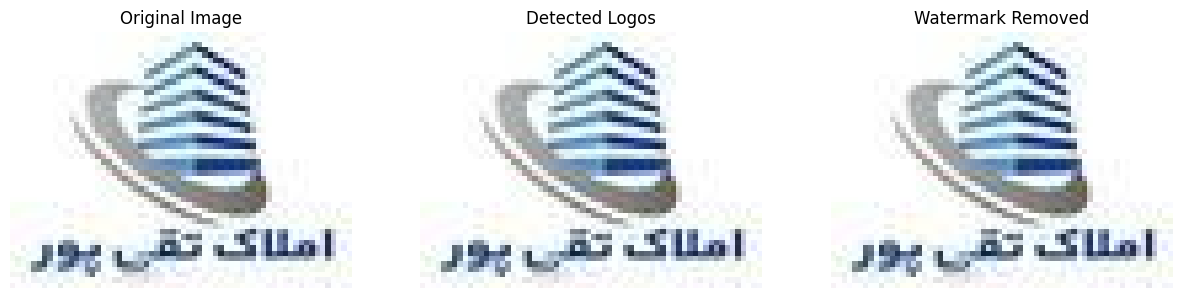

Testing image: 098_year-of-building.webp

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/098_year-of-building.webp: 640x640 1 logo, 3051.2ms
Speed: 4.5ms preprocess, 3051.2ms inference, 25.1ms postprocess per image at shape (1, 3, 640, 640)


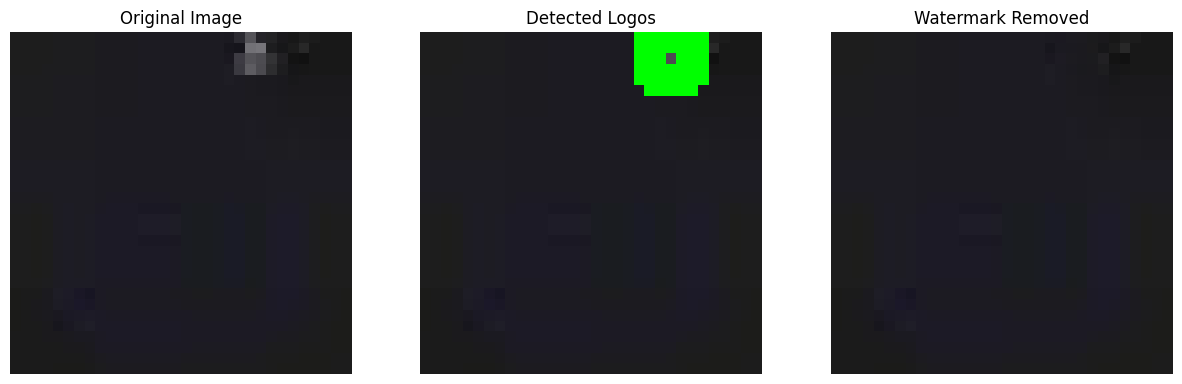

Testing image: 451988954_859575f93101a2e0887ba752357a59b8.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/451988954_859575f93101a2e0887ba752357a59b8.webp.jpeg: 416x640 1 logo, 2481.3ms
Speed: 3.8ms preprocess, 2481.3ms inference, 6.4ms postprocess per image at shape (1, 3, 416, 640)


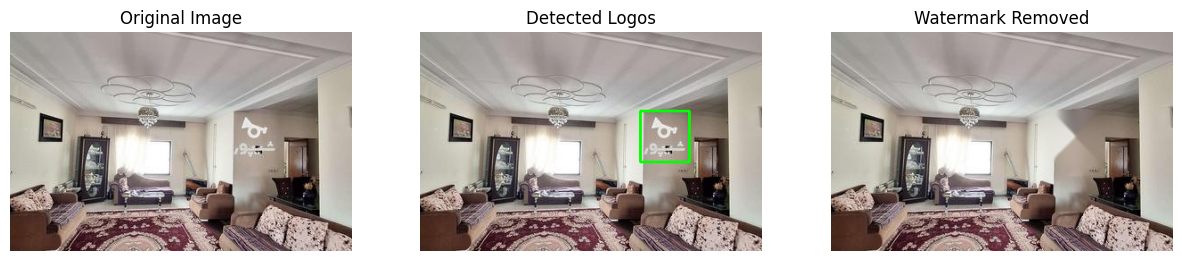

Testing image: Image.webp_16.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/Image.webp_16.jpeg: 480x640 1 logo, 4172.9ms
Speed: 3.4ms preprocess, 4172.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


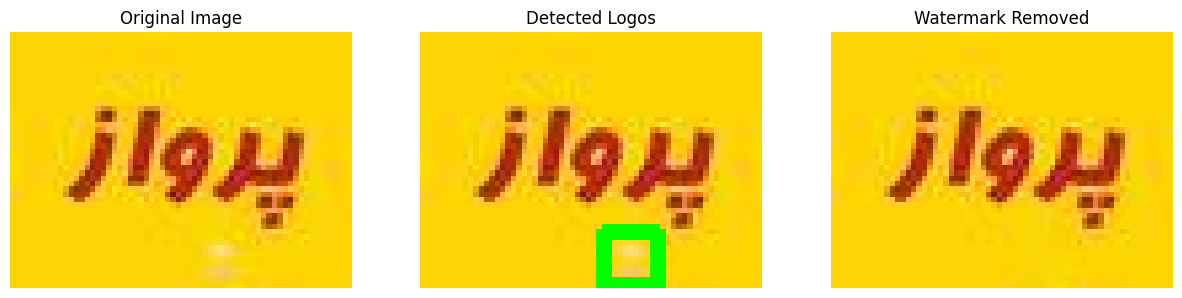

Testing image: 031_65ecc3cb-adf1-4fe3-99be-db04f6a62e08$Frame-128.webp

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/031_65ecc3cb-adf1-4fe3-99be-db04f6a62e08$Frame-128.webp: 640x640 1 logo, 2708.1ms
Speed: 5.2ms preprocess, 2708.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


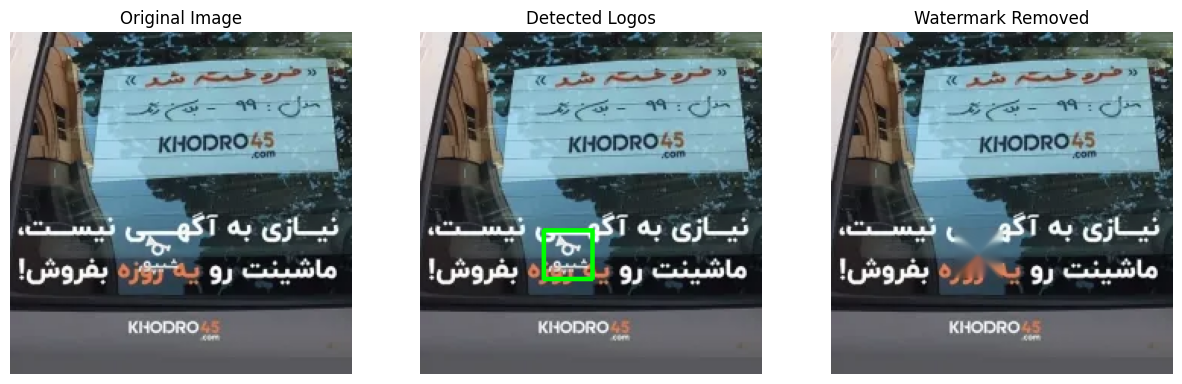

Testing image: ecunion.f1e36b7d.png

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/ecunion.f1e36b7d.png: 640x640 1 logo, 2742.1ms
Speed: 6.6ms preprocess, 2742.1ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)


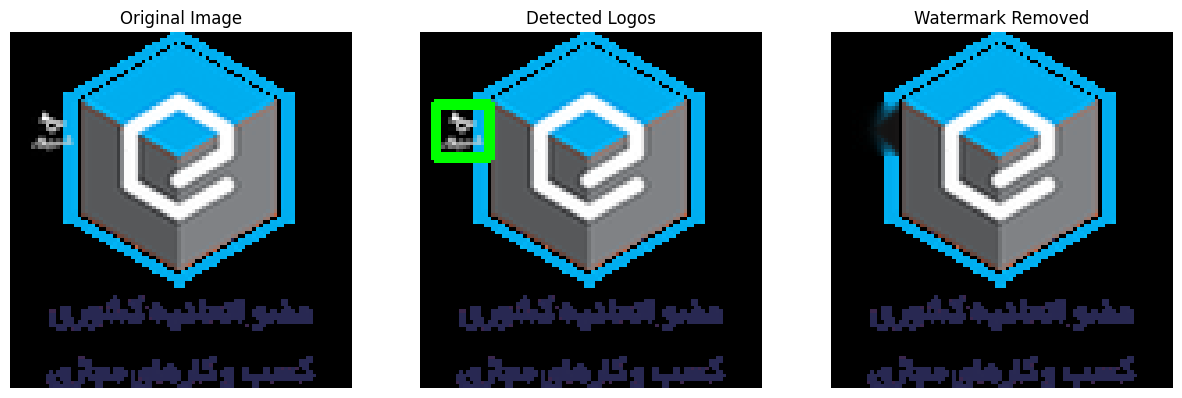

Testing image: 025_452015763_9a307d1aa75647f01f7a851a2b32ad5a.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/025_452015763_9a307d1aa75647f01f7a851a2b32ad5a.webp.jpeg: 416x640 1 logo, 1636.9ms
Speed: 3.9ms preprocess, 1636.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


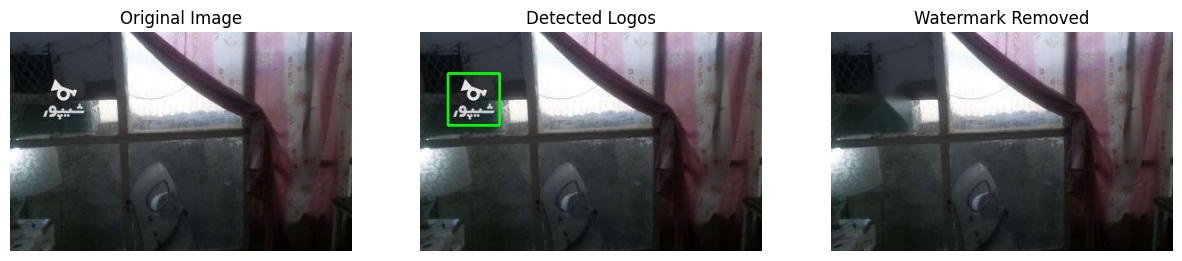

Testing image: 452097099_6d04fe87f2c22d6e16c40658f8097433.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/452097099_6d04fe87f2c22d6e16c40658f8097433.webp.jpeg: 480x640 1 logo, 2068.5ms
Speed: 5.1ms preprocess, 2068.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


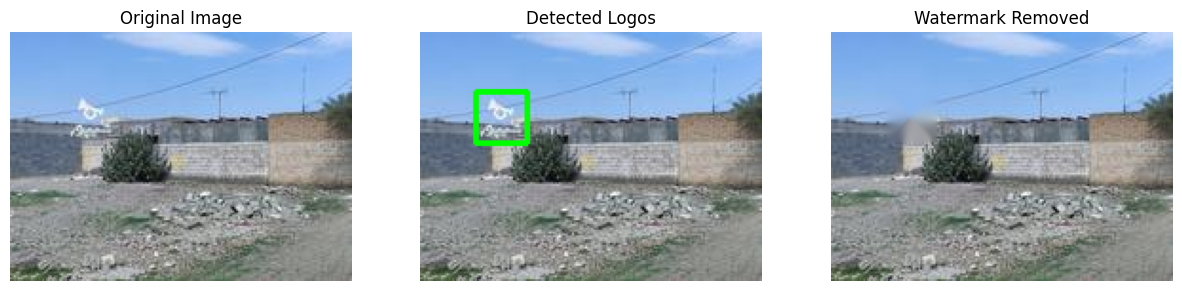

Testing image: 046_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/046_Image.webp.jpeg: 640x640 1 logo, 2155.9ms
Speed: 4.2ms preprocess, 2155.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


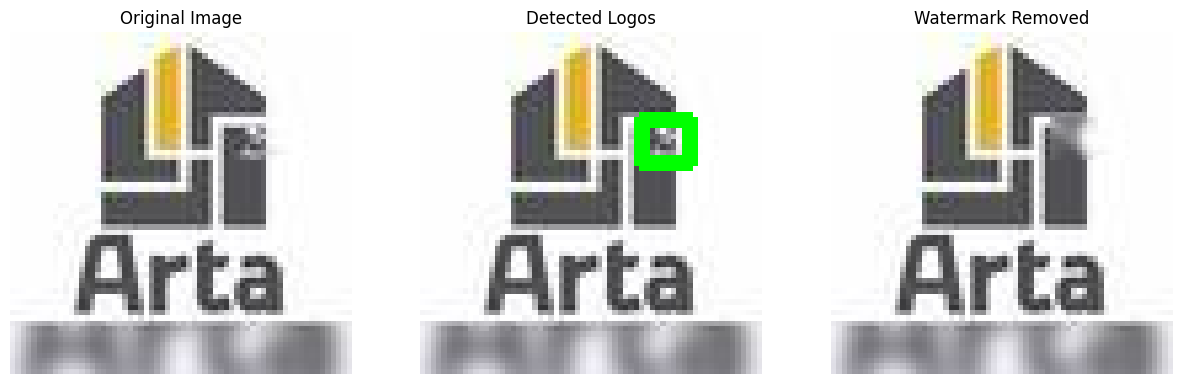

Testing image: 452097103_ba07f3571bc990b02556f7c836d13a9b.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark remover/dataset/images/val/452097103_ba07f3571bc990b02556f7c836d13a9b.webp.jpeg: 416x640 1 logo, 917.8ms
Speed: 2.5ms preprocess, 917.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


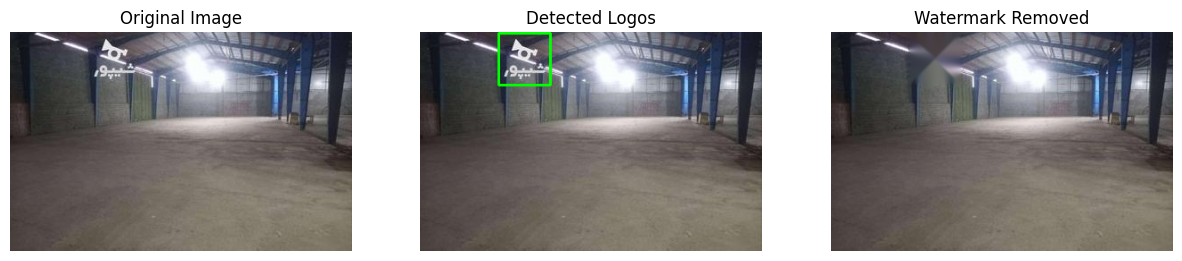

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
from pathlib import Path

model = YOLO("logo_detection/yolo11m_logo_run/weights/best.pt")

test_folder = Path("dataset/images/val")
test_images = list(test_folder.glob("*.*"))
test_images = random.sample(test_images, min(10, len(test_images)))

def visualize_detection_and_removal(model, img_path):
    results = model(str(img_path))[0]

    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_boxes = img.copy()
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(img_boxes, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,255,0), 2)

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        mask[y1:y2, x1:x2] = 255

    inpainted = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Detected Logos")
    plt.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Watermark Removed")
    plt.imshow(inpainted_rgb)
    plt.axis('off')

    plt.show()

for img_path in test_images:
    print(f"Testing image: {img_path.name}")
    visualize_detection_and_removal(model, img_path)

In [ ]:
!pip install -U gdown ultralytics wandb scikit-learn

In [ ]:
# 1. Install / upgrade required packages
#!pip install -U gdown ultralytics wandb scikit-learn requests

import os
import shutil
import zipfile
import random
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import gdown

# 2. Mount Google Drive and set working directory
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark_remover')
os.makedirs(gdrive_path, exist_ok=True)
os.chdir(gdrive_path)
print(f"Working directory: {os.getcwd()}")

# 3. Dataset ZIP file names and Google Drive file IDs
dataset_zips = [
    "www_sheypoor_com-1747494277481.zip",
    "www_sheypoor_com-1747493066552.zip"
]
file_ids = [
    "1iTdjpjlE5M-d9OwpdCu5yrs8e5dBjWxd",  # Replace with actual ID
    "1iTdjpjlE5M-d9OwpdCu5yrs8e5dBjWxd"   # Replace with actual ID
]

# 4. Download ZIP files if missing
for zip_name, file_id in zip(dataset_zips, file_ids):
    zip_path = gdrive_path / zip_name
    if not zip_path.exists():
        print(f"Downloading {zip_name}...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(zip_path), quiet=False)
    else:
        print(f"{zip_name} already exists, skipping download.")

# 5. Extract ZIP files freshly
for zip_name in dataset_zips:
    zip_path = gdrive_path / zip_name
    extract_folder = gdrive_path / zip_name.replace(".zip", "")
    if extract_folder.exists():
        shutil.rmtree(extract_folder)
    if zip_path.exists():
        print(f"Extracting {zip_name} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
    else:
        print(f"ZIP file {zip_name} not found, skipping extraction.")

# 6. Download Sheypoor logo if missing
logo_filename = "Sheypoor_logo.png"
logo_url = "https://drive.google.com/uc?id=1iXCpOke2vf3bpTl9FYz79w-GGGgI4nea"
logo_path = gdrive_path / logo_filename
if not logo_path.exists():
    print(f"Downloading logo sample {logo_filename} ...")
    gdown.download(logo_url, str(logo_path), quiet=False)
else:
    print(f"{logo_filename} already exists, skipping download.")

# 7. Collect all images from extracted folders
image_extensions = (".jpg", ".jpeg", ".png", ".webp")
raw_images = []
for folder in [gdrive_path / z.replace(".zip", "") for z in dataset_zips]:
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(image_extensions):
                raw_images.append(os.path.join(root, f))
print(f"Collected {len(raw_images)} images for watermarking.")

if len(raw_images) == 0:
    raise RuntimeError("No images found in dataset folders. Please verify dataset download and extraction.")

# 8. Prepare output folders for dataset
output_base = Path("dataset")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (output_base / sub).mkdir(parents=True, exist_ok=True)

# 9. Function to add resized watermark logo and create YOLO label
def add_resized_logo_and_label(base_image_path, logo_image_path,
                               output_image_path, output_label_path,
                               class_id=0):
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)
    if logo_target_width <= 0 or logo_target_height <= 0:
        print(f"Invalid logo size for {base_image_path}, skipping.")
        return False

    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)
    logo_w, logo_h = logo_img_resized.size
    max_x, max_y = base_w - logo_w, base_h - logo_h
    if max_x < 0 or max_y < 0:
        print(f"Logo larger than image {base_image_path}, skipping.")
        return False

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)
    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # YOLO format: class x_center y_center width height (normalized)
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return True

# 10. Create watermarked images and labels in temp folders
temp_img_folder = Path("temp_watermarked_images")
temp_label_folder = Path("temp_labels")
if temp_img_folder.exists():
    shutil.rmtree(temp_img_folder)
if temp_label_folder.exists():
    shutil.rmtree(temp_label_folder)
temp_img_folder.mkdir()
temp_label_folder.mkdir()

print("Creating watermarked images and labels...")
for img_path in raw_images:
    img_name = os.path.basename(img_path)
    out_img_path = temp_img_folder / img_name
    out_label_path = temp_label_folder / (os.path.splitext(img_name)[0] + ".txt")
    add_resized_logo_and_label(img_path, logo_path, out_img_path, out_label_path)

# 11. Verify labels exist and non-empty
missing_labels = []
empty_labels = []
for img_file in os.listdir(temp_img_folder):
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = temp_label_folder / label_file
    if not label_path.exists():
        missing_labels.append(label_file)
    elif label_path.stat().st_size == 0:
        empty_labels.append(label_file)

print(f"Missing labels: {missing_labels}")
print(f"Empty labels: {empty_labels}")
assert not missing_labels and not empty_labels, "Fix missing or empty labels before training!"

# 12. Split dataset into train/val (90%/10%)
all_images = list(temp_img_folder.glob("*.*"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.1, random_state=42)

def move_files(file_list, dst_img_folder, dst_label_folder):
    for img_path in file_list:
        img_name = img_path.name
        label_name = img_path.with_suffix('.txt').name
        shutil.copy(img_path, dst_img_folder / img_name)
        shutil.copy(temp_label_folder / label_name, dst_label_folder / label_name)

move_files(train_imgs, output_base / "images/train", output_base / "labels/train")
move_files(val_imgs,   output_base / "images/val",   output_base / "labels/val")

# 13. Create data.yaml for YOLOv11 training
data_yaml = f"""
train: {str(output_base / 'images/train')}
val:   {str(output_base / 'images/val')}

nc: 1
names: ['logo']
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)
print("data.yaml created.")

# 14. Set WANDB API key (replace with your key)
os.environ["WANDB_API_KEY"] = "22f2597b648c0fe02188c9eef60adfb0daa0728a"

# 15. Remove stale cache if exists
if os.path.exists("watermarked_images.cache"):
    os.remove("watermarked_images.cache")

# 16. Train YOLOv11m model with augmentations and tuned hyperparameters
from ultralytics import YOLO
import wandb

wandb.login()

# Use the correct weight name so Ultralytics auto-downloads it if missing
model = YOLO("yolo11m.pt")

model.train(
    data="data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    project="logo_detection",
    name="yolo11m_logo_run",
    exist_ok=True,
    save=True,
    save_txt=True,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    fliplr=0.5,
    mixup=0.1,
    mosaic=1.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    translate=0.1
)

print("Training complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/Colab/Watermark_remover
www_sheypoor_com-1747494277481.zip already exists, skipping download.
www_sheypoor_com-1747493066552.zip already exists, skipping download.
Extracting www_sheypoor_com-1747494277481.zip ...
Extracting www_sheypoor_com-1747493066552.zip ...
Sheypoor_logo.png already exists, skipping download.
Collected 176 images for watermarking.
Creating watermarked images and labels...
Logo larger than image /content/drive/MyDrive/Colab/Watermark_remover/www_sheypoor_com-1747494277481/090_d17307e42f5034ec.webp, skipping.
Logo larger than image /content/drive/MyDrive/Colab/Watermark_remover/www_sheypoor_com-1747493066552/090_d17307e42f5034ec.webp, skipping.
Missing labels: []
Empty labels: []
data.yaml created.


100%|██████████| 38.8M/38.8M [00:00<00:00, 161MB/s]


Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_logo_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

train: Scanning /content/drive/MyDrive/Colab/Watermark_remover/dataset/labels/train... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:01<00:00, 56.61it/s]

train: New cache created: /content/drive/MyDrive/Colab/Watermark_remover/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 1.1±1.0 MB/s, size: 3.1 KB)


val: Scanning /content/drive/MyDrive/Colab/Watermark_remover/dataset/labels/val... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 84.22it/s]

val: New cache created: /content/drive/MyDrive/Colab/Watermark_remover/dataset/labels/val.cache


Plotting labels to logo_detection/yolo11m_logo_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to logo_detection/yolo11m_logo_run
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/5 [00:00<?, ?it/s]

Testing image: 079_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/079_Image.webp.jpeg: 480x640 1 logo, 54.8ms
Speed: 2.0ms preprocess, 54.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


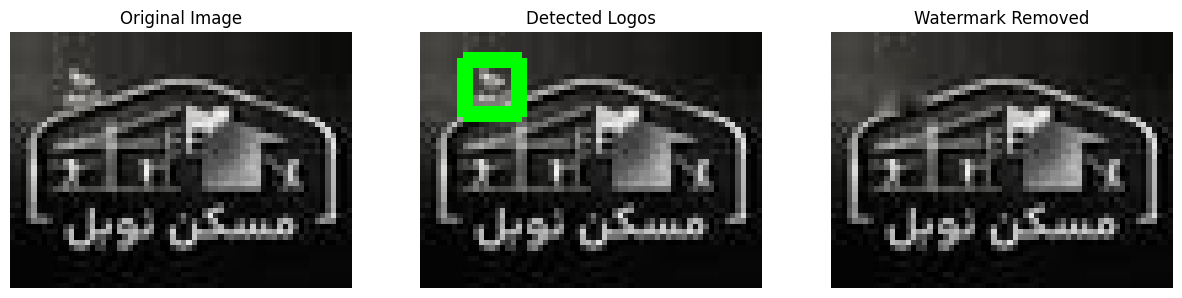

Testing image: 023_452056999_c2b050f3bf858c5c0d669a56a8916673.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/023_452056999_c2b050f3bf858c5c0d669a56a8916673.webp.jpeg: 416x640 1 logo, 53.4ms
Speed: 2.8ms preprocess, 53.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


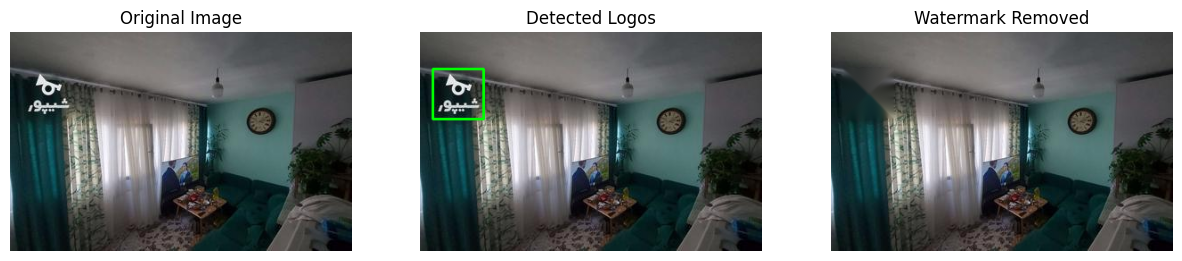

Testing image: 013_449353337_6afb2b60b4737781c001dc5e69ea5194.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/013_449353337_6afb2b60b4737781c001dc5e69ea5194.webp.jpeg: 640x640 1 logo, 38.1ms
Speed: 4.6ms preprocess, 38.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


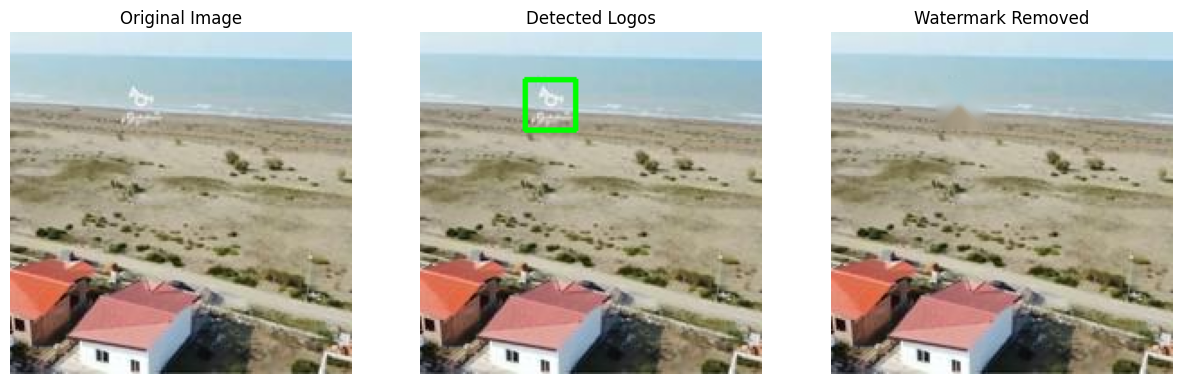

Testing image: 001_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/001_Image.webp.jpeg: 480x640 2 logos, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


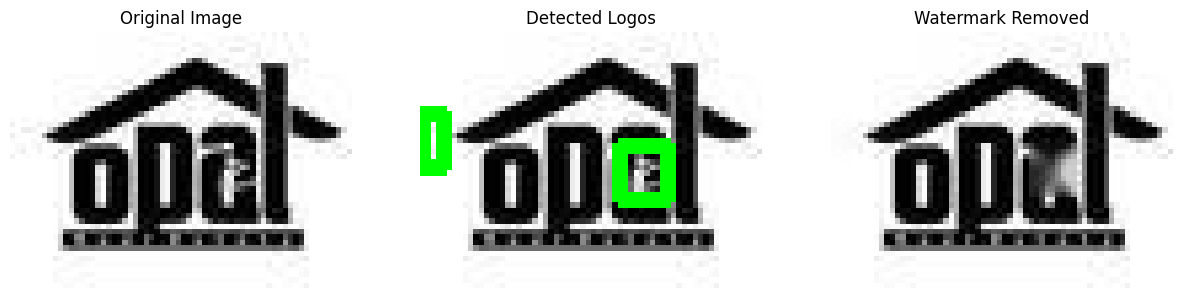

Testing image: 027_floor.webp

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/027_floor.webp: 640x640 1 logo, 38.0ms
Speed: 4.7ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


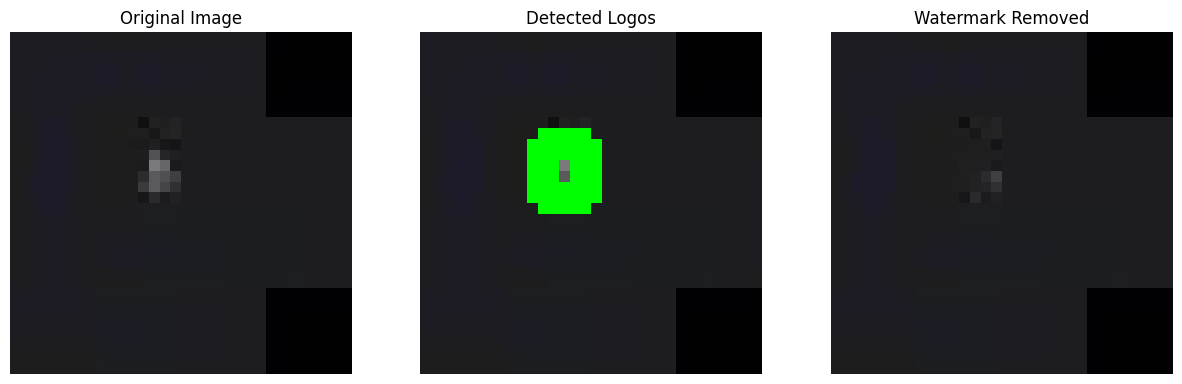

Testing image: 005_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/005_Image.webp.jpeg: 480x640 (no detections), 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


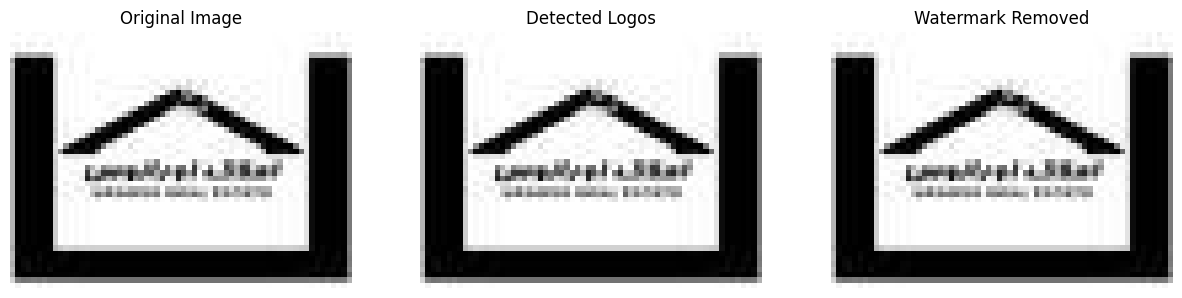

Testing image: 088_452079853_fa3062280e8afc7d0bb2988ed117bf0d.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/088_452079853_fa3062280e8afc7d0bb2988ed117bf0d.webp.jpeg: 480x640 1 logo, 29.4ms
Speed: 3.5ms preprocess, 29.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


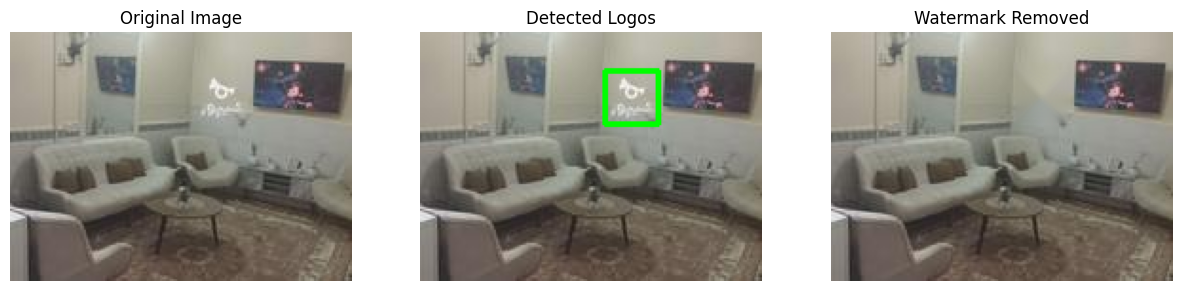

Testing image: 019_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/019_Image.webp.jpeg: 448x640 (no detections), 58.3ms
Speed: 2.6ms preprocess, 58.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


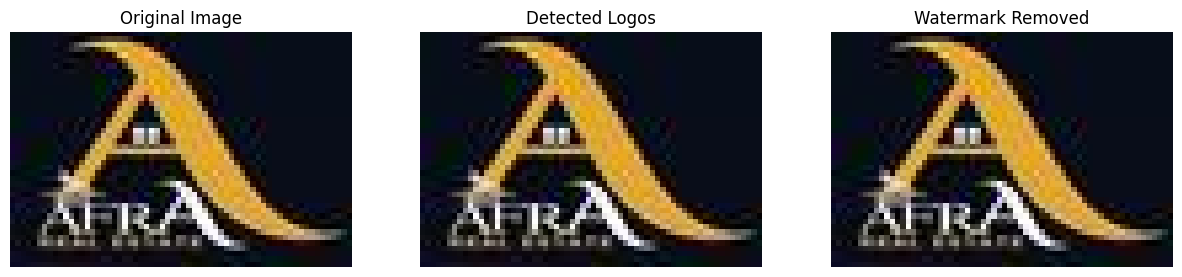

Testing image: 011_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/011_Image.webp.jpeg: 640x640 1 logo, 38.0ms
Speed: 3.7ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


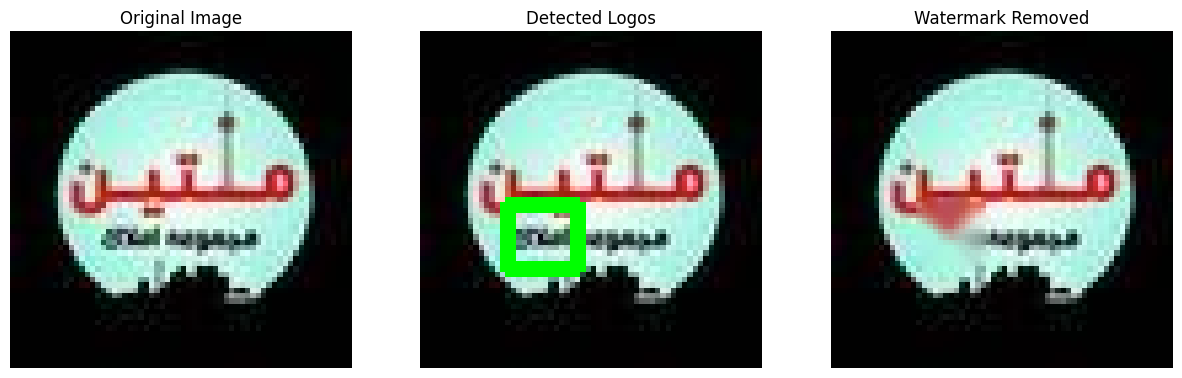

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
from pathlib import Path

# بارگذاری مدل آموزش‌دیده (مسیر را مطابق محل ذخیره وزن‌ها تنظیم کنید)
model = YOLO("logo_detection/yolo11m_logo_run/weights/best.pt")

# مسیر پوشه تصاویر تست
test_folder = Path("dataset/images/val")
test_images = list(test_folder.glob("*.*"))
test_images = random.sample(test_images, min(10, len(test_images)))  # انتخاب تصادفی 10 تصویر یا کمتر

def visualize_detection_and_removal(model, img_path):
    # پیش‌بینی مدل روی تصویر
    results = model(str(img_path))[0]

    # خواندن تصویر با OpenCV و تبدیل به RGB برای نمایش
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # تصویر با جعبه‌های تشخیص لوگو
    img_boxes = img.copy()
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(img_boxes, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,255,0), 2)

    # ساخت ماسک لوگوها
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        mask[y1:y2, x1:x2] = 255

    # حذف واترمارک با inpainting
    inpainted = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    # نمایش تصاویر
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Detected Logos")
    plt.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Watermark Removed")
    plt.imshow(inpainted_rgb)
    plt.axis('off')

    plt.show()

# اجرای تست روی تصاویر نمونه
for img_path in test_images:
    print(f"Testing image: {img_path.name}")
    visualize_detection_and_removal(model, img_path)

Choose input method:
1: Upload image file
2: Enter image URL
Enter 1 or 2: 1


Saving 450603273_efe5975bdb230f69020fb487850b33e0.webp to 450603273_efe5975bdb230f69020fb487850b33e0.webp

0: 480x640 1 logo, 30.5ms
Speed: 5.9ms preprocess, 30.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


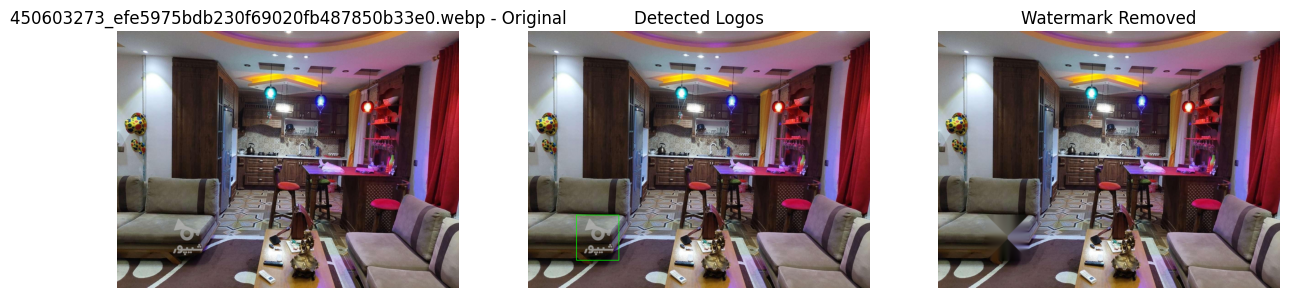

Processed uploaded image: 450603273_efe5975bdb230f69020fb487850b33e0.webp


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
import random
import requests
from io import BytesIO
from PIL import Image
from google.colab import files

# بارگذاری مدل آموزش‌دیده (مسیر وزن‌ها را تنظیم کنید)
model = YOLO("logo_detection/yolo11m_logo_run/weights/best.pt")

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)[:, :, ::-1]  # PIL RGB -> OpenCV BGR

def visualize_detection_and_removal(model, img_bgr, img_name="Input Image"):
    results = model(img_bgr)[0]

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_boxes = img_bgr.copy()

    # رسم جعبه‌های تشخیص لوگو
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(img_boxes, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,255,0), 2)

    # ساخت ماسک لوگوها
    mask = np.zeros(img_bgr.shape[:2], dtype=np.uint8)
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        mask[y1:y2, x1:x2] = 255

    # حذف لوگو با inpainting
    inpainted = cv2.inpaint(img_bgr, mask, 3, cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    # نمایش تصاویر
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title(f"{img_name} - Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Detected Logos")
    plt.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Watermark Removed")
    plt.imshow(inpainted_rgb)
    plt.axis('off')

    plt.show()

# --- انتخاب ورودی: آپلود یا URL ---
print("Choose input method:")
print("1: Upload image file")
print("2: Enter image URL")
choice = input("Enter 1 or 2: ").strip()

if choice == "1":
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_path = Path(filename)
        img_bgr = cv2.imread(str(img_path))
        visualize_detection_and_removal(model, img_bgr, img_name=filename)
        print(f"Processed uploaded image: {filename}")

elif choice == "2":
    url = input("Enter image URL: ").strip()
    try:
        img_bgr = load_image_from_url(url)
        visualize_detection_and_removal(model, img_bgr, img_name=url)
        print(f"Processed image from URL: {url}")
    except Exception as e:
        print(f"Failed to load or process image from URL: {e}")

else:
    print("Invalid choice. Please run again and select 1 or 2.")

### Testing on random dataset images ###
Testing image: 013_449353337_6afb2b60b4737781c001dc5e69ea5194.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/013_449353337_6afb2b60b4737781c001dc5e69ea5194.webp.jpeg: 640x640 1 logo, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


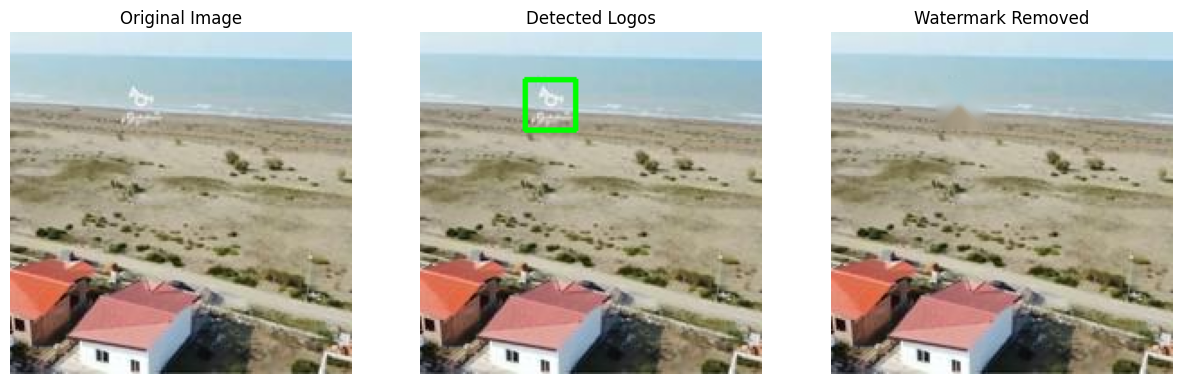

Testing image: 001_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/001_Image.webp.jpeg: 480x640 2 logos, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


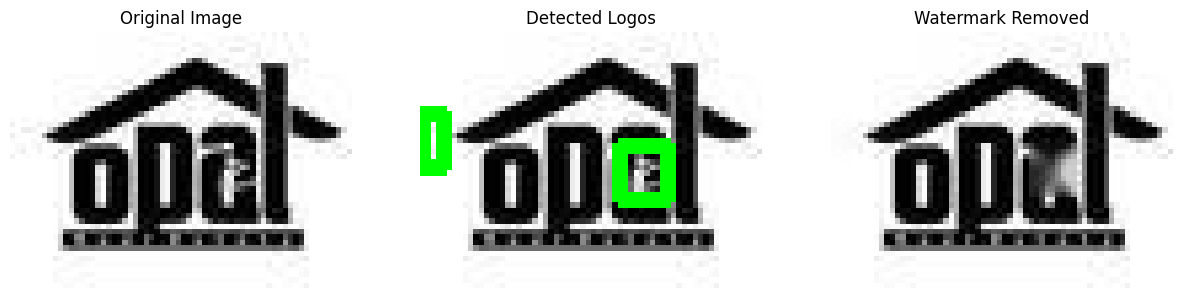

Testing image: 079_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/079_Image.webp.jpeg: 480x640 1 logo, 28.2ms
Speed: 2.7ms preprocess, 28.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


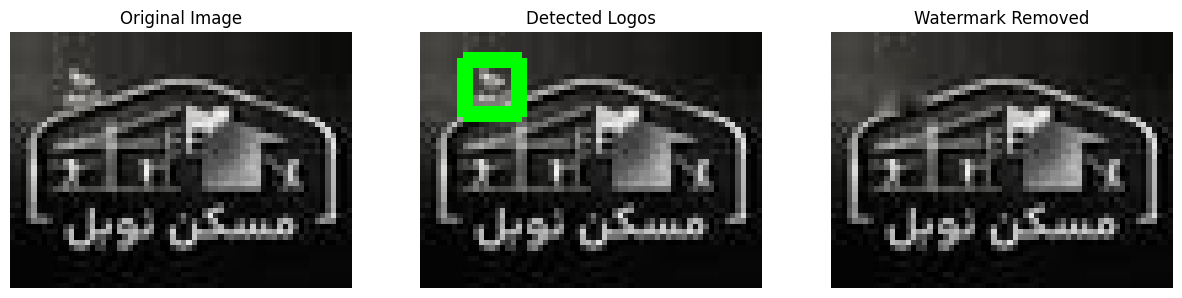

Testing image: 088_452079853_fa3062280e8afc7d0bb2988ed117bf0d.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/088_452079853_fa3062280e8afc7d0bb2988ed117bf0d.webp.jpeg: 480x640 1 logo, 28.2ms
Speed: 3.1ms preprocess, 28.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


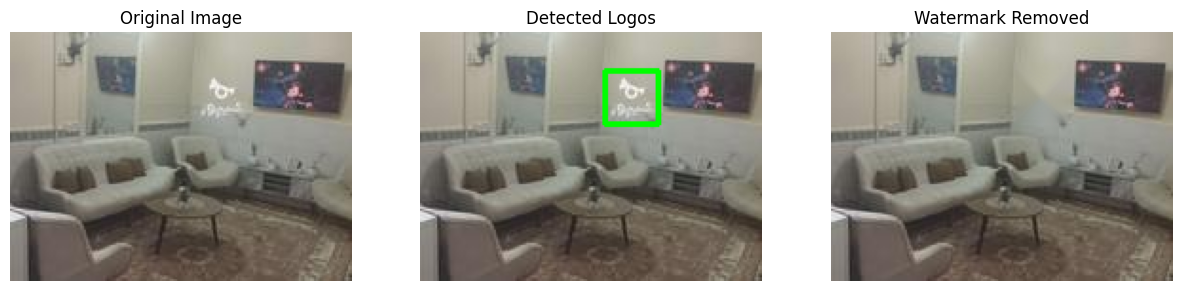

Testing image: 027_floor.webp

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/027_floor.webp: 640x640 1 logo, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)


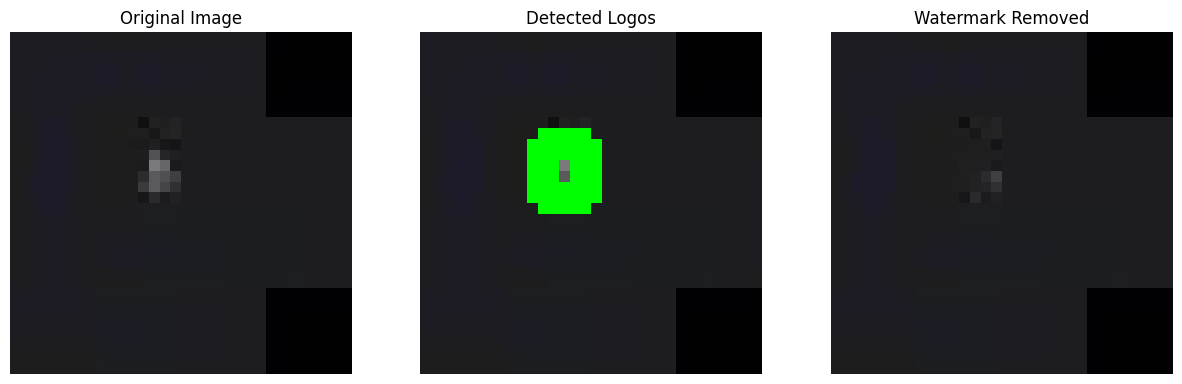

Testing image: 023_452056999_c2b050f3bf858c5c0d669a56a8916673.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/023_452056999_c2b050f3bf858c5c0d669a56a8916673.webp.jpeg: 416x640 1 logo, 32.8ms
Speed: 2.9ms preprocess, 32.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


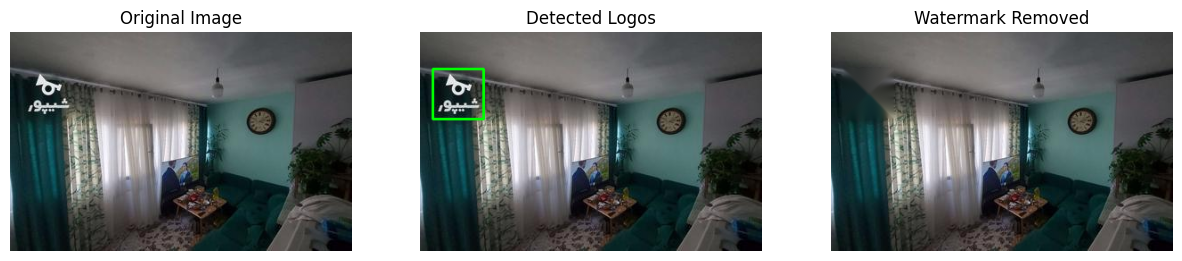

Testing image: 005_Image.webp.jpeg

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/dataset/images/val/005_Image.webp.jpeg: 480x640 (no detections), 31.8ms
Speed: 2.8ms preprocess, 31.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


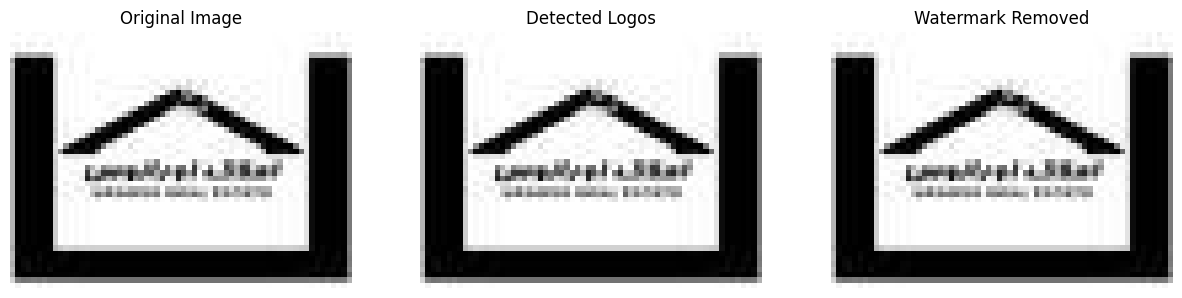

### Testing on default URL images ###
Testing default image #1

0: 640x352 1 logo, 78.4ms
Speed: 3.4ms preprocess, 78.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 352)


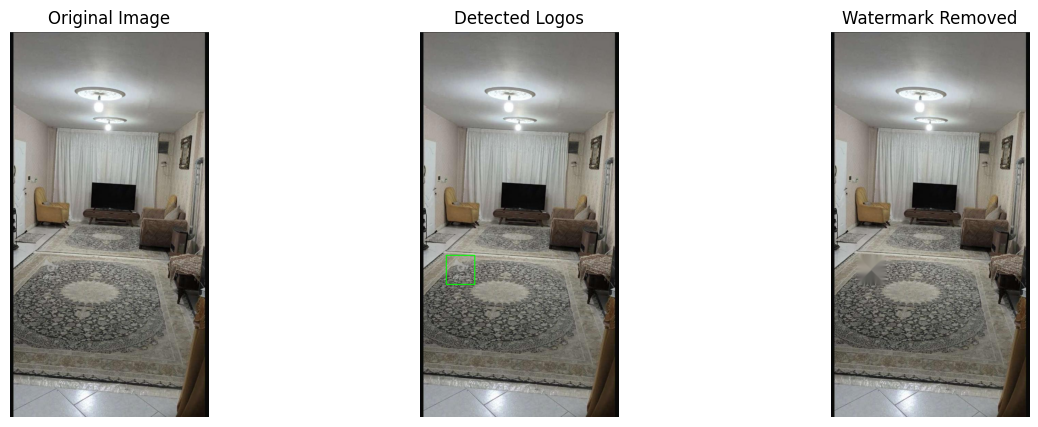

Testing default image #2

0: 640x384 (no detections), 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


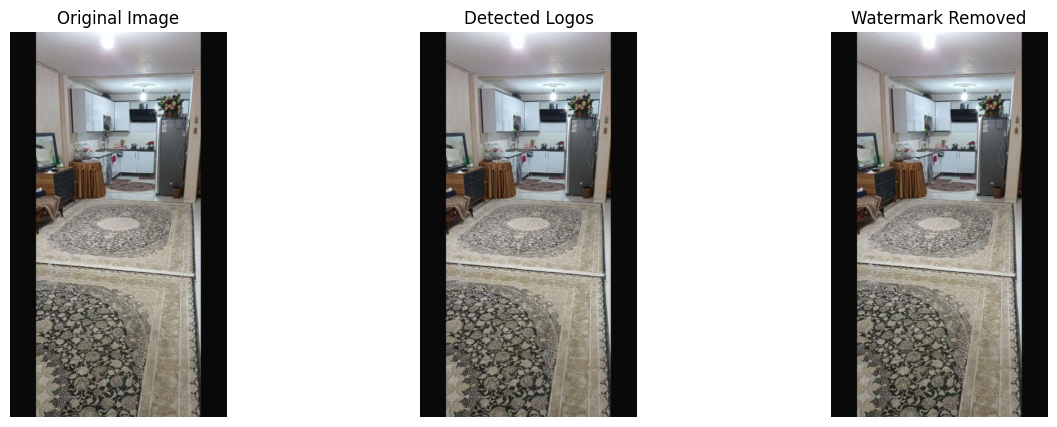

Testing default image #3

0: 640x352 1 logo, 27.7ms
Speed: 2.8ms preprocess, 27.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


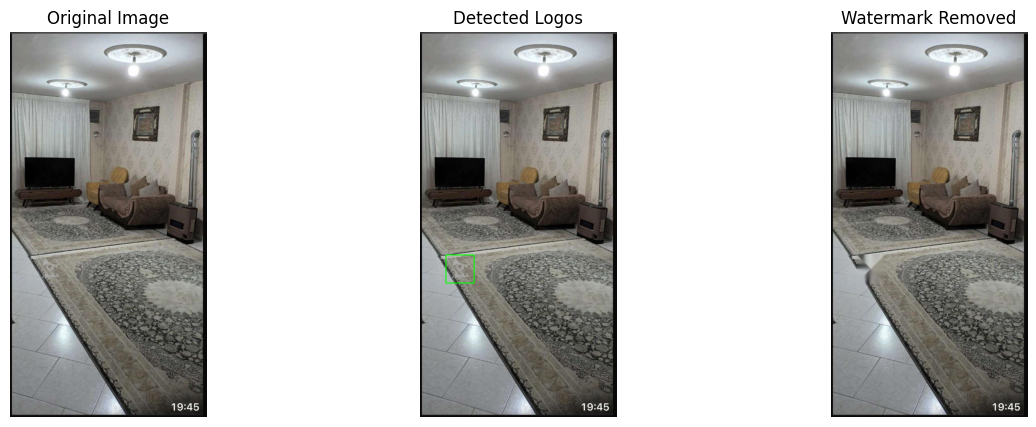

Testing default image #4

0: 640x352 (no detections), 27.1ms
Speed: 3.9ms preprocess, 27.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


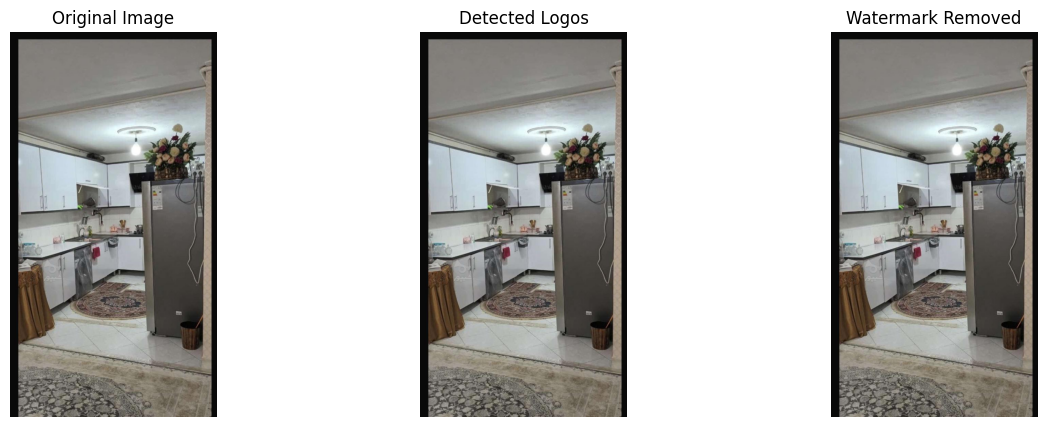

Testing default image #5

0: 320x640 1 logo, 102.7ms
Speed: 3.0ms preprocess, 102.7ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


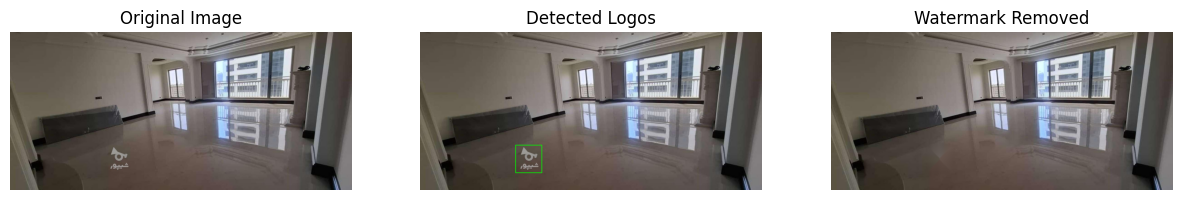

Testing default image #6

0: 640x512 (no detections), 96.9ms
Speed: 8.5ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


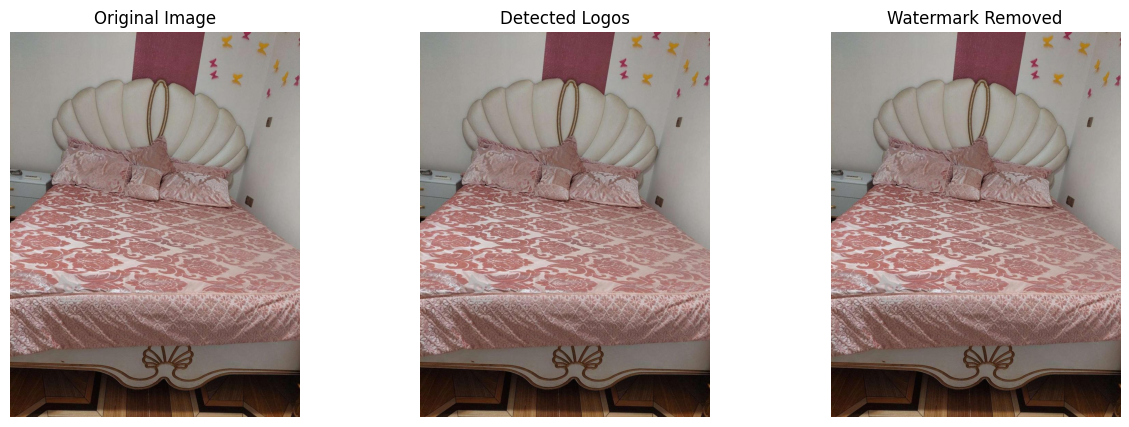


Choose input method:
1: Upload image file
2: Enter image URL
Enter choice (1 or 2): 1


Saving 451547916_97346ad26339ce2c9521f97f15f1298b.webp to 451547916_97346ad26339ce2c9521f97f15f1298b.webp
Uploaded image: 451547916_97346ad26339ce2c9521f97f15f1298b.webp

image 1/1 /content/drive/MyDrive/Colab/Watermark_remover/451547916_97346ad26339ce2c9521f97f15f1298b.webp: 640x384 (no detections), 36.4ms
Speed: 3.9ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


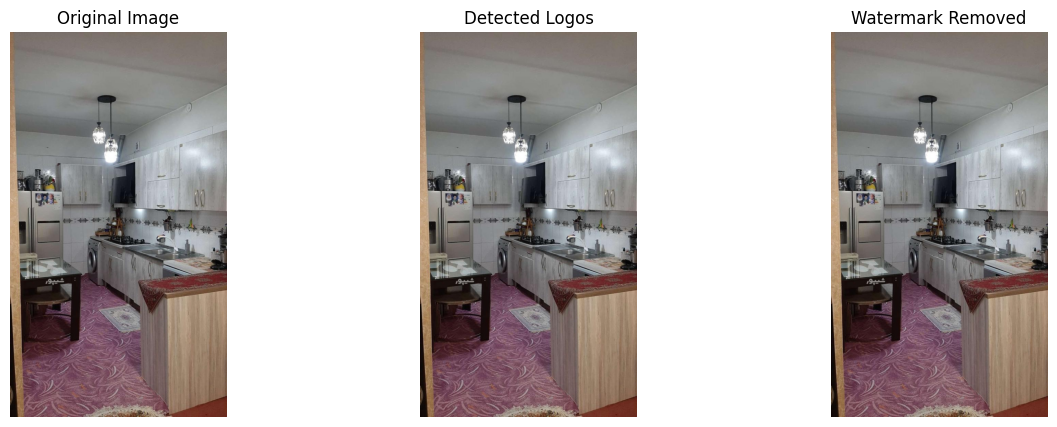

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
from pathlib import Path
import requests
from io import BytesIO
from PIL import Image
from google.colab import files

# بارگذاری مدل آموزش‌دیده (مسیر وزن‌ها را متناسب با پروژه خود تغییر دهید)
model = YOLO("logo_detection/yolo11m_logo_run/weights/best.pt")

# مسیر پوشه تصاویر تست دیتاست
test_folder = Path("dataset/images/val")
image_extensions = (".jpg", ".jpeg", ".png", ".webp")

# 1. انتخاب حدود 7 تصویر تصادفی از دیتاست
all_images = [p for p in test_folder.rglob("*") if p.suffix.lower() in image_extensions]
random_dataset_images = random.sample(all_images, min(7, len(all_images)))

# 2. تصاویر نمونه پیش‌فرض از URLها
default_images_urls = [
    "https://i.sstatic.net/pBClQA3f.jpg",
    "https://i.sstatic.net/LhZcESfd.jpg",
    "https://i.sstatic.net/EDdJ8syZ.jpg",
    "https://i.sstatic.net/FyMuaSJV.jpg",
    "https://i.sstatic.net/26GPXl2M.jpg",
    "https://i.sstatic.net/D8kJfL4E.jpg"
]

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

default_images = []
for url in default_images_urls:
    try:
        img = load_image_from_url(url)
        default_images.append(img)
    except Exception as e:
        print(f"Failed to load image from {url}: {e}")

# تابع نمایش تصویر با تشخیص و حذف لوگو
def visualize_detection_and_removal(model, img):
    # img می‌تواند مسیر فایل یا آرایه PIL.Image یا numpy باشد
    if isinstance(img, (str, Path)):
        results = model(str(img))[0]
        img_cv = cv2.imread(str(img))
    elif isinstance(img, Image.Image):
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        results = model(img_cv)[0]
    else:
        img_cv = img
        results = model(img_cv)[0]

    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_boxes = img_cv.copy()

    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(img_boxes, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)

    mask = np.zeros(img_cv.shape[:2], dtype=np.uint8)
    for box in results.boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        mask[y1:y2, x1:x2] = 255

    inpainted = cv2.inpaint(img_cv, mask, 3, cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Detected Logos")
    plt.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Watermark Removed")
    plt.imshow(inpainted_rgb)
    plt.axis('off')

    plt.show()

# 3. نمایش تصاویر دیتاست و تصاویر پیش‌فرض
print("### Testing on random dataset images ###")
for img_path in random_dataset_images:
    print(f"Testing image: {img_path.name}")
    visualize_detection_and_removal(model, img_path)

print("### Testing on default URL images ###")
for i, img in enumerate(default_images):
    print(f"Testing default image #{i+1}")
    visualize_detection_and_removal(model, img)

# 4. دریافت تصویر از کاربر (آپلود یا URL)
def user_input_image_test():
    print("\nChoose input method:")
    print("1: Upload image file")
    print("2: Enter image URL")
    choice = input("Enter choice (1 or 2): ").strip()

    if choice == "1":
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded.")
            return
        img_path = list(uploaded.keys())[0]
        print(f"Uploaded image: {img_path}")
        visualize_detection_and_removal(model, img_path)

    elif choice == "2":
        url = input("Enter image URL: ").strip()
        try:
            img = load_image_from_url(url)
            print("Image loaded from URL.")
            visualize_detection_and_removal(model, img)
        except Exception as e:
            print(f"Failed to load image from URL: {e}")

    else:
        print("Invalid choice.")

# 5. اجرای دریافت تصویر از کاربر
user_input_image_test()

# Making the bigger dataset for it to better training:(

In [ ]:
# 1. نصب پکیج‌های مورد نیاز
!pip install -U gdown ultralytics wandb scikit-learn requests

In [ ]:


import os
import shutil
import zipfile
import random
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import gdown

# 2. اتصال به گوگل درایو و تنظیم مسیر کاری
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark_remover')
os.makedirs(gdrive_path, exist_ok=True)
os.chdir(gdrive_path)
print(f"Working directory: {os.getcwd()}")

# 3. دانلود دیتاست LogoDet-3K از لینک مستقیم (لینک سرور یا جایگزین معتبر)
logodet3k_url = "https://123.57.42.89/Dataset_ict/LogoDet-3K.zip"  # لینک نمونه؛ در صورت نیاز لینک معتبر جایگزین شود
logodet3k_zip = gdrive_path / "LogoDet-3K.zip"

if not logodet3k_zip.exists():
    print("Downloading LogoDet-3K dataset...")
    gdown.download(logodet3k_url, str(logodet3k_zip), quiet=False)
else:
    print("LogoDet-3K.zip already exists, skipping download.")

# 4. استخراج دیتاست
extract_folder = gdrive_path / "LogoDet-3K"
if extract_folder.exists():
    shutil.rmtree(extract_folder)
with zipfile.ZipFile(logodet3k_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Extracted LogoDet-3K to {extract_folder}")

# 5. دانلود لوگوی واترمارک اگر موجود نیست
logo_filename = "Sheypoor_logo.png"
logo_url = "https://drive.google.com/uc?id=1iXCpOke2vf3bpTl9FYz79w-GGGgI4nea"
logo_path = gdrive_path / logo_filename
if not logo_path.exists():
    print(f"Downloading logo sample {logo_filename} ...")
    gdown.download(logo_url, str(logo_path), quiet=False)
else:
    print(f"{logo_filename} already exists, skipping download.")

# 6. جمع‌آوری تصاویر دیتاست (فرض بر این است تصاویر در پوشه‌ای مانند extract_folder/images هستند)
image_extensions = (".jpg", ".jpeg", ".png", ".webp")
raw_images = []
images_folder = extract_folder / "images"  # مسیر واقعی تصاویر را با توجه به ساختار دیتاست تنظیم کنید
for root, _, files in os.walk(images_folder):
    for f in files:
        if f.lower().endswith(image_extensions):
            raw_images.append(os.path.join(root, f))
print(f"Collected {len(raw_images)} images for watermarking.")

if len(raw_images) == 0:
    raise RuntimeError("No images found in dataset folders. Please verify dataset extraction and path.")

# 7. آماده‌سازی پوشه‌های خروجی
output_base = Path("dataset")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (output_base / sub).mkdir(parents=True, exist_ok=True)

# 8. تابع افزودن لوگوی واترمارک و ساخت برچسب YOLO
def add_resized_logo_and_label(base_image_path, logo_image_path,
                               output_image_path, output_label_path,
                               class_id=0):
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)
    if logo_target_width <= 0 or logo_target_height <= 0:
        print(f"Invalid logo size for {base_image_path}, skipping.")
        return False

    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)
    logo_w, logo_h = logo_img_resized.size
    max_x, max_y = base_w - logo_w, base_h - logo_h
    if max_x < 0 or max_y < 0:
        print(f"Logo larger than image {base_image_path}, skipping.")
        return False

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)
    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # فرمت YOLO: class x_center y_center width height (نرمال‌شده)
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return True

# 9. ساخت تصاویر واترمارک‌دار و برچسب‌ها در پوشه موقت
temp_img_folder = Path("temp_watermarked_images")
temp_label_folder = Path("temp_labels")
if temp_img_folder.exists():
    shutil.rmtree(temp_img_folder)
if temp_label_folder.exists():
    shutil.rmtree(temp_label_folder)
temp_img_folder.mkdir()
temp_label_folder.mkdir()

print("Creating watermarked images and labels...")
for img_path in raw_images:
    img_name = os.path.basename(img_path)
    out_img_path = temp_img_folder / img_name
    out_label_path = temp_label_folder / (os.path.splitext(img_name)[0] + ".txt")
    add_resized_logo_and_label(img_path, logo_path, out_img_path, out_label_path)

# 10. بررسی وجود و غیرخالی بودن برچسب‌ها
missing_labels = []
empty_labels = []
for img_file in os.listdir(temp_img_folder):
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = temp_label_folder / label_file
    if not label_path.exists():
        missing_labels.append(label_file)
    elif label_path.stat().st_size == 0:
        empty_labels.append(label_file)

print(f"Missing labels: {missing_labels}")
print(f"Empty labels: {empty_labels}")
assert not missing_labels and not empty_labels, "Fix missing or empty labels before training!"

# 11. تقسیم دیتاست به train/val (۹۰٪/۱۰٪)
all_images = list(temp_img_folder.glob("*.*"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.1, random_state=42)

def move_files(file_list, dst_img_folder, dst_label_folder):
    for img_path in file_list:
        img_name = img_path.name
        label_name = img_path.with_suffix('.txt').name
        shutil.copy(img_path, dst_img_folder / img_name)
        shutil.copy(temp_label_folder / label_name, dst_label_folder / label_name)

move_files(train_imgs, output_base / "images/train", output_base / "labels/train")
move_files(val_imgs, output_base / "images/val", output_base / "labels/val")

# 12. ساخت فایل data.yaml برای آموزش YOLOv11
data_yaml = f"""
train: {str(output_base / 'images/train')}
val:   {str(output_base / 'images/val')}

nc: 1
names: ['logo']
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)
print("data.yaml created.")

# 13. تنظیم کلید API برای WANDB (کلید خود را جایگزین کنید)
os.environ["WANDB_API_KEY"] = "22f2597b648c0fe02188c9eef60adfb0daa0728a"

# 14. حذف کش قدیمی در صورت وجود
if os.path.exists("watermarked_images.cache"):
    os.remove("watermarked_images.cache")

# 15. آموزش مدل YOLOv11m با تنظیمات پیشرفته
from ultralytics import YOLO
import wandb

wandb.login()

model = YOLO("yolov11m.pt")

model.train(
    data="data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    project="logo_detection",
    name="yolo11m_logo_run",
    exist_ok=True,
    save=True,
    save_txt=True,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    fliplr=0.5,
    mixup=0.1,
    mosaic=1.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    translate=0.1
)

print("Training complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/Colab/Watermark_remover


ConnectionError: HTTPSConnectionPool(host='123.57.42.89', port=443): Max retries exceeded with url: /Dataset_ict/LogoDet-3K.zip (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7d3e76e54810>: Failed to establish a new connection: [Errno 111] Connection refused'))

# The huggingface available model :(

In [1]:
# 1. Install required packages
!pip install -U gdown ultralytics wandb scikit-learn requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:


import os
import shutil
import zipfile
import random
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import gdown

# 2. Mount Google Drive and set working directory
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark_remover')
os.makedirs(gdrive_path, exist_ok=True)
os.chdir(gdrive_path)
print(f"Working directory: {os.getcwd()}")

# 3. Download FlickrLogos-32 dataset (use a mirror or upload manually if needed)
dataset_url = "https://www.multimedia-computing.de/flickrlogos/flickrlogos_32_dataset.zip"
dataset_zip = gdrive_path / "flickrlogos_32_dataset.zip"

if not dataset_zip.exists():
    print("Downloading FlickrLogos-32 dataset...")
    gdown.download(dataset_url, str(dataset_zip), quiet=False)
else:
    print("Dataset ZIP already exists, skipping download.")

# 4. Extract dataset
extract_folder = gdrive_path / "flickrlogos_32_dataset"
if extract_folder.exists():
    shutil.rmtree(extract_folder)
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Extracted dataset to {extract_folder}")

# 5. Download watermark logo if missing
logo_filename = "Sheypoor_logo.png"
logo_url = "https://drive.google.com/uc?id=1iXCpOke2vf3bpTl9FYz79w-GGGgI4nea"
logo_path = gdrive_path / logo_filename
if not logo_path.exists():
    print(f"Downloading watermark logo {logo_filename} ...")
    gdown.download(logo_url, str(logo_path), quiet=False)
else:
    print(f"{logo_filename} already exists, skipping download.")

# 6. Collect images from dataset (adjust path according to extracted structure)
image_extensions = (".jpg", ".jpeg", ".png", ".webp")
raw_images = []
images_folder = extract_folder / "images"  # adjust if needed
for root, _, files in os.walk(images_folder):
    for f in files:
        if f.lower().endswith(image_extensions):
            raw_images.append(os.path.join(root, f))
print(f"Collected {len(raw_images)} images.")

if len(raw_images) == 0:
    raise RuntimeError("No images found in dataset. Check dataset extraction path.")

# 7. Prepare output folders
output_base = Path("dataset")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (output_base / sub).mkdir(parents=True, exist_ok=True)

# 8. Function to add watermark logo and create YOLO label
def add_resized_logo_and_label(base_image_path, logo_image_path,
                               output_image_path, output_label_path,
                               class_id=0):
    base_img = Image.open(base_image_path).convert("RGBA")
    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)

    if logo_target_width <= 0 or logo_target_height <= 0:
        print(f"Invalid logo size for {base_image_path}, skipping.")
        return False

    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)
    logo_w, logo_h = logo_img_resized.size
    max_x, max_y = base_w - logo_w, base_h - logo_h

    if max_x < 0 or max_y < 0:
        print(f"Logo larger than image {base_image_path}, skipping.")
        return False

    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)
    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # YOLO format: class x_center y_center width height (normalized)
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return True

# 9. Create watermarked images and labels in temp folders
temp_img_folder = Path("temp_watermarked_images")
temp_label_folder = Path("temp_labels")
if temp_img_folder.exists():
    shutil.rmtree(temp_img_folder)
if temp_label_folder.exists():
    shutil.rmtree(temp_label_folder)
temp_img_folder.mkdir()
temp_label_folder.mkdir()

print("Creating watermarked images and labels...")
for img_path in raw_images:
    img_name = os.path.basename(img_path)
    out_img_path = temp_img_folder / img_name
    out_label_path = temp_label_folder / (os.path.splitext(img_name)[0] + ".txt")
    add_resized_logo_and_label(img_path, logo_path, out_img_path, out_label_path)

# 10. Verify labels
missing_labels = []
empty_labels = []
for img_file in os.listdir(temp_img_folder):
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = temp_label_folder / label_file
    if not label_path.exists():
        missing_labels.append(label_file)
    elif label_path.stat().st_size == 0:
        empty_labels.append(label_file)

print(f"Missing labels: {missing_labels}")
print(f"Empty labels: {empty_labels}")
assert not missing_labels and not empty_labels, "Fix missing or empty labels before training!"

# 11. Split dataset into train/val 90/10
all_images = list(temp_img_folder.glob("*.*"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.1, random_state=42)

def move_files(file_list, dst_img_folder, dst_label_folder):
    for img_path in file_list:
        img_name = img_path.name
        label_name = img_path.with_suffix('.txt').name
        shutil.copy(img_path, dst_img_folder / img_name)
        shutil.copy(temp_label_folder / label_name, dst_label_folder / label_name)

move_files(train_imgs, output_base / "images/train", output_base / "labels/train")
move_files(val_imgs, output_base / "images/val", output_base / "labels/val")

# 12. Create data.yaml
data_yaml = f"""
train: {str(output_base / 'images/train')}
val:   {str(output_base / 'images/val')}

nc: 1
names: ['logo']
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)
print("data.yaml created.")

# 13. Set WANDB API key
os.environ["WANDB_API_KEY"] = "22f2597b648c0fe02188c9eef60adfb0daa0728a"

# 14. Remove stale cache
if os.path.exists("watermarked_images.cache"):
    os.remove("watermarked_images.cache")

# 15. Train YOLOv11m model
from ultralytics import YOLO
import wandb

wandb.login()

model = YOLO("yolov11m.pt")
model.train(
    data="data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    project="logo_detection",
    name="yolo11m_logo_run",
    exist_ok=True,
    save=True,
    save_txt=True,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    fliplr=0.5,
    mixup=0.1,
    mosaic=1.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    translate=0.1
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 68.4 MB/s eta 0:00:01

In [ ]:
import os
import shutil
import tarfile
import random
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import gdown
import requests

# Function to get remote file size in bytes
def get_remote_file_size(url):
    response = requests.head(url, allow_redirects=True)
    size = response.headers.get('Content-Length')
    if size is None:
        return None
    return int(size)

# Function to get local file size (None if file doesn't exist)
def get_local_file_size(filepath):
    try:
        return os.path.getsize(filepath)
    except FileNotFoundError:
        return None

# 1. Mount Google Drive and set working directory
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

gdrive_path = Path('/content/drive/MyDrive/Colab/Watermark_remover')
os.makedirs(gdrive_path, exist_ok=True)
os.chdir(gdrive_path)
print(f"Working directory: {os.getcwd()}")

# 2. Dataset download parameters
dataset_url = "https://zenodo.org/record/5101018/files/litw_cleaned.tar.gz"
dataset_tar = gdrive_path / "litw_cleaned.tar.gz"

# 3. Check remote and local file sizes to avoid re-downloading
remote_size = get_remote_file_size(dataset_url)
local_size = get_local_file_size(dataset_tar)

if local_size is not None and remote_size is not None and local_size == remote_size:
    print(f"Local dataset file exists and matches remote size ({local_size} bytes). Skipping download.")
else:
    print(f"Downloading dataset file from {dataset_url} ...")
    gdown.download(dataset_url, str(dataset_tar), quiet=False)


# 4. Extract the tar.gz dataset only if not already extracted
extract_folder = gdrive_path / "litw_cleaned"
if not extract_folder.exists():
    with tarfile.open(dataset_tar, 'r:gz') as tar_ref:
        tar_ref.extractall(extract_folder)
    print(f"Extracted dataset to {extract_folder}")
else:
    print(f"Dataset folder {extract_folder} already exists, skipping extraction.")

# 5. Download watermark logo if missing
logo_filename = "Sheypoor_logo.png"
logo_url = "https://drive.google.com/uc?id=1iXCpOke2vf3bpTl9FYz79w-GGGgI4nea"
logo_path = gdrive_path / logo_filename
if not logo_path.exists():
    print(f"Downloading watermark logo {logo_filename} ...")
    gdown.download(logo_url, str(logo_path), quiet=False)
else:
    print(f"{logo_filename} already exists, skipping download.")

# 6. Collect all images recursively from extracted dataset
image_extensions = (".jpg", ".jpeg", ".png", ".webp")
raw_images = []
for root, _, files in os.walk(extract_folder):
    for f in files:
        if f.lower().endswith(image_extensions):
            raw_images.append(os.path.join(root, f))
print(f"Collected {len(raw_images)} images.")

if len(raw_images) == 0:
    raise RuntimeError("No images found in dataset. Check dataset extraction path.")

# 7. Prepare output folders for YOLOv11 format
output_base = Path("dataset")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (output_base / sub).mkdir(parents=True, exist_ok=True)

# 8. Function to add watermark logo resized to 15% of image width and create YOLO label
def add_resized_logo_and_label(base_image_path, logo_image_path,
                               output_image_path, output_label_path,
                               class_id=0):
    try:
        base_img = Image.open(base_image_path).convert("RGBA")
    except UnidentifiedImageError:
        print(f"Cannot open image file {base_image_path}, skipping.")
        return False

    logo_img = Image.open(logo_image_path).convert("RGBA")

    base_w, base_h = base_img.size
    # Minimum image size threshold (adjust as needed)
    min_width, min_height = 50, 50
    if base_w < min_width or base_h < min_height:
        print(f"Image too small ({base_w}x{base_h}): {base_image_path}, skipping.")
        return False

    # Resize logo to 15% of base image width
    logo_target_width = int(base_w * 0.15)
    aspect_ratio = logo_img.height / logo_img.width
    logo_target_height = int(logo_target_width * aspect_ratio)

    # Validate logo size
    if logo_target_width <= 0 or logo_target_height <= 0:
        print(f"Invalid logo size for {base_image_path}, skipping.")
        return False

    if logo_target_width > base_w or logo_target_height > base_h:
        print(f"Logo larger than image {base_image_path}, skipping.")
        return False

    logo_img_resized = logo_img.resize((logo_target_width, logo_target_height), Image.LANCZOS)
    logo_w, logo_h = logo_img_resized.size
    max_x, max_y = base_w - logo_w, base_h - logo_h

    # Random position within image bounds
    x_min = random.randint(0, max_x)
    y_min = random.randint(0, max_y)

    base_img.paste(logo_img_resized, (x_min, y_min), logo_img_resized)
    base_img.convert("RGB").save(output_image_path)

    # YOLO format: class x_center y_center width height (normalized)
    x_center = (x_min + logo_w / 2) / base_w
    y_center = (y_min + logo_h / 2) / base_h
    width = logo_w / base_w
    height = logo_h / base_h

    with open(output_label_path, "w") as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return True

# 9. Create watermarked images and labels in temporary folders
temp_img_folder = Path("temp_watermarked_images")
temp_label_folder = Path("temp_labels")
if temp_img_folder.exists():
    shutil.rmtree(temp_img_folder)
if temp_label_folder.exists():
    shutil.rmtree(temp_label_folder)
temp_img_folder.mkdir()
temp_label_folder.mkdir()

print("Creating watermarked images and labels...")

skipped_files = 0
processed_files = 0

for img_path in raw_images:
    img_name = os.path.basename(img_path)
    out_img_path = temp_img_folder / img_name
    out_label_path = temp_label_folder / (os.path.splitext(img_name)[0] + ".txt")
    try:
        success = add_resized_logo_and_label(img_path, logo_path, out_img_path, out_label_path)
        if success:
            processed_files += 1
        else:
            skipped_files += 1
    except Exception as e:
        print(f"Error processing {img_path}: {e}, skipping.")
        skipped_files += 1

print(f"Watermarking done. Processed: {processed_files}, Skipped: {skipped_files}")

# 10. Verify labels
missing_labels = []
empty_labels = []
for img_file in os.listdir(temp_img_folder):
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = temp_label_folder / label_file
    if not label_path.exists():
        missing_labels.append(label_file)
    elif label_path.stat().st_size == 0:
        empty_labels.append(label_file)

print(f"Missing labels: {missing_labels}")
print(f"Empty labels: {empty_labels}")
assert not missing_labels and not empty_labels, "Fix missing or empty labels before training!"

# 11. Split dataset into train/val (90%/10%)
all_images = list(temp_img_folder.glob("*.*"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.1, random_state=42)

def move_files(file_list, dst_img_folder, dst_label_folder):
    for img_path in file_list:
        img_name = img_path.name
        label_name = img_path.with_suffix('.txt').name
        shutil.copy(img_path, dst_img_folder / img_name)
        shutil.copy(temp_label_folder / label_name, dst_label_folder / label_name)

move_files(train_imgs, output_base / "images/train", output_base / "labels/train")
move_files(val_imgs, output_base / "images/val", output_base / "labels/val")

# 12. Create data.yaml for YOLOv11 training
data_yaml = f"""
train: {str(output_base / 'images/train')}
val:   {str(output_base / 'images/val')}

nc: 1
names: ['logo']
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)
print("data.yaml created.")

# 13. Set WANDB API key if using Weights & Biases (optional)
os.environ["WANDB_API_KEY"] = "22f2597b648c0fe02188c9eef60adfb0daa0728a"

# 14. Train YOLOv11 model
from ultralytics import YOLO
import wandb

wandb.login()

model = YOLO("yolov11m.pt")
model.train(
    data="data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    project="logo_detection",
    name="yolo11m_logo_run",
    exist_ok=True,
    save=True,
    save_txt=True,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    fliplr=0.5,
    mixup=0.1,
    mosaic=1.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    translate=0.1
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/Colab/Watermark_remover
Local dataset file exists and matches remote size (2135404601 bytes). Skipping download.
Dataset folder /content/drive/MyDrive/Colab/Watermark_remover/litw_cleaned already exists, skipping extraction.
Sheypoor_logo.png already exists, skipping download.


## Step 1️: Define a sweep

A W&B Sweep combines a strategy for trying numerous hyperparameter values with the code that evaluates them.
Before you start a sweep, you must define your sweep strategy with a _sweep configuration_.


:::info
The sweep configuration you create for a sweep must be in a nested dictionary if you start a sweep in a Jupyter Notebook.

If you run a sweep within the command line, you must specify your sweep config with a [YAML file](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration).
:::

### Pick a search method

First, specify a hyperparameter search method within your configuration dictionary. [There are three hyperparameter search strategies to choose from: grid, random, and Bayesian search](https://docs.wandb.ai/guides/sweeps/sweep-config-keys#method).

For this tutorial, you will use a random search. Within your notebook, create a dictionary and specify `random` for the `method` key.

In [ ]:
sweep_config = {
    'method': 'random'
    }

Specify a metric that you want to optimize for. You do not need to specify the metric and goal for sweeps that use random search method. However, it is good practice to keep track of your sweep goals because you can refer to it at a later time.

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

### Specify hyperparameters to search through

Now that you have a search method specified in your sweep configuration, specify the hyperparameters you want to search over.

To do this, specify one or more hyperparameter names to the `parameter` key and specify one or more hyperparameter values for the `value` key.

The values you search through for a given hyperparamter depend on the the type of hyperparameter you are investigating.  

For example, if you choose a machine learning optimizer, you must specify one or more finite optimizer names such as the Adam optimizer and stochastic gradient dissent.

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

Sometimes you want to track a hyperparameter, but not vary its value. In this case, add the hyperparameter to your sweep configuration and specify the exact value that you want to use. For example, in the following code cell, `epochs` is set to 1.

In [ ]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

For a `random` search,
all the `values` of a parameter are equally likely to be chosen on a given run.

Alternatively,
you can specify a named `distribution`,
plus its parameters, like the mean `mu`
and standard deviation `sigma` of a `normal` distribution.

In [ ]:
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    })

When we're finished, `sweep_config` is a nested dictionary
that specifies exactly which `parameters` we're interested in trying
and the `method` we're going to use to try them.

Let's see how the sweep configuration looks like:

In [ ]:
import pprint
pprint.pprint(sweep_config)

For a full list of configuration options, see [Sweep configuration options](https://docs.wandb.ai/guides/sweeps/sweep-config-keys).

:::tip
For hyperparameters that have potentially infinite options,
it usually makes sense to try out
a few select `values`. For example, the preceding sweep configuration has a list of finite values specified for the `layer_size` and `dropout` parameter keys.
:::

## Step 2️: Initialize the Sweep

Once you've defined the search strategy, it's time to set up something to implement it.

W&B uses a Sweep Controller to manage sweeps on the cloud or locally across one or more machines. For this tutorial, you will use a sweep controller managed by W&B.

While sweep controllers manage sweeps, the component that actually executes a sweep is known as a _sweep agent_.


:::info
By default, sweep controllers components are initiated on W&B's servers and sweep agents, the component that creates sweeps, are activated on your local machine.
:::


Within your notebook, you can activate a sweep controller with the `wandb.sweep` method. Pass your sweep configuration dictionary you defined earlier to the `sweep_config` field:

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

The `wandb.sweep` function returns a `sweep_id` that you will use at a later step to activate your sweep.

:::info
On the command line, this function is replaced with
```python
wandb sweep config.yaml
```
:::

For more information on how to create W&B Sweeps in a terminal, see the [W&B Sweep walkthrough](https://docs.wandb.com/sweeps/walkthrough).


## Step 3:  Define your machine learning code

Before you execute the sweep,
define the training procedure that uses the hyperparameter values you want to try. The key to integrating W&B Sweeps into your training code is to ensure that, for each training experiment, that your training logic can access the hyperparameter values you defined in your sweep configuration.

In the proceeding code example, the helper functions `build_dataset`, `build_network`, `build_optimizer`, and `train_epoch` access the sweep hyperparameter configuration dictionary.

Run the proceeding machine learning training code in your notebook. The functions define a basic fully-connected neural network in PyTorch.

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})

Within the `train` function, you will notice the following W&B Python SDK methods:
* [`wandb.init()`](https://docs.wandb.com/library/init) – Initialize a new W&B run. Each run is a single execution of the training function.
* [`wandb.config`](https://docs.wandb.com/library/config) – Pass sweep configuration with the hyperparameters you want to experiment with.
* [`wandb.log()`](https://docs.wandb.com/library/log) – Log the training loss for each epoch.


The proceeding cell defines four functions:
`build_dataset`, `build_network`, `build_optimizer`, and `train_epoch`.
These functions are a standard part of a basic PyTorch pipeline,
and their implementation is unaffected by the use of W&B.

In [ ]:
def build_dataset(batch_size):

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)


def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

For more details on instrumenting W&B with PyTorch, see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb).

## Step 4: Activate sweep agents
Now that you have your sweep configuration defined and a training script that can utilize those hyperparameter in an interactive way, you are ready to activate a sweep agent. Sweep agents are responsible for running an experiment with a set of hyperparameter values that you defined in your sweep configuration.

Create sweep agents with the `wandb.agent` method. Provide the following:
1. The sweep the agent is a part of (`sweep_id`)
2. The function the sweep is supposed to run. In this example, the sweep will use the `train` function.
3. (optionally) How many configs to ask the sweep controller for (`count`)

:::tip
You can start multiple sweep agents with the same `sweep_id`
on different compute resources. The sweep controller ensures that they work together
according to the sweep configuration you defined.
:::

The proceeding cell activates a sweep agent that runs the training function (`train`) 5 times:

In [ ]:
wandb.agent(sweep_id, train, count=5)

:::info
Since the `random` search method was specified in the sweep configuration, the sweep controller provides randomly-generated hyperparameter values.
:::

For more information on how to create W&B Sweeps in a terminal, see the [W&B Sweep walkthrough](https://docs.wandb.com/sweeps/walkthrough).

## Visualize Sweep Results



### Parallel Coordinates Plot
This plot maps hyperparameter values to model metrics. It’s useful for honing in on combinations of hyperparameters that led to the best model performance.

![](https://assets.website-files.com/5ac6b7f2924c652fd013a891/5e190366778ad831455f9af2_s_194708415DEC35F74A7691FF6810D3B14703D1EFE1672ED29000BA98171242A5_1578695138341_image.png)


### Hyperparameter Importance Plot
The hyperparameter importance plot surfaces which hyperparameters were the best predictors of your metrics.
We report feature importance (from a random forest model) and correlation (implicitly a linear model).

![](https://assets.website-files.com/5ac6b7f2924c652fd013a891/5e190367778ad820b35f9af5_s_194708415DEC35F74A7691FF6810D3B14703D1EFE1672ED29000BA98171242A5_1578695757573_image.png)

These visualizations can help you save both time and resources running expensive hyperparameter optimizations by honing in on the parameters (and value ranges) that are the most important, and thereby worthy of further exploration.


## Learn more about W&B Sweeps

We created a simple training script and [a few flavors of sweep configs](https://github.com/wandb/examples/tree/master/examples/keras/keras-cnn-fashion) for you to play with. We highly encourage you to give these a try.

That repo also has examples to help you try more advanced sweep features like [Bayesian Hyperband](https://app.wandb.ai/wandb/examples-keras-cnn-fashion/sweeps/us0ifmrf?workspace=user-lavanyashukla), and [Hyperopt](https://app.wandb.ai/wandb/examples-keras-cnn-fashion/sweeps/xbs2wm5e?workspace=user-lavanyashukla).